
# RNN Dead Layer Fit Project

## Abigail Alexander, Aobo Li


## Plan:

1) Generating MC spectrums with different [FCCD Width, Dead Layer Ratio, transfer function], normalize them to contain the same number of events -> Done

2) Randomly pull out 2 MC spectrum(MC1 and MC2) and subtract them to obtain MCdiff = (MC1-MC2)

3) Feed MCdiff into RNN and train to answer questions: is FCCD Width of MC1>MC2? is dead layer ration of MC1>MC2? etc.
    
    - RNN: https://github.com/legend-exp/gem/blob/master/NetworkPSA/NetworkPSA_RNN.ipynb

4) Use the traditional peak-fitting technology you and Valentina developed, this will give you a MC spectrum given certain dead layer parameters, let’s call it MCbest

5) Calculate a new difference by doing MC_newdiff = Data-MCbest, then feeding MC_newdiff into the trained RNN. RNN will tell you if the [FCCD width, dead layer ratio,…] in MCbest is too low/too high.

6) Looking at the attention score, this will tell you which part of the spectrum the network has used to make the decision.

7) Trying to understand why a too low/too high FCCD width would have that kind of effect on that part of the spectrum, is it because of the MC simulation? transfer function? etc.

# ---------------------------------------------
# CLASSES AND FUNCTIONS
# ---------------------------------------------

# Import packages

In [1]:
#check env
import os
print (os.environ['CONDA_DEFAULT_ENV'])

/unix/legend/abi/ML_DL/MLenv


In [2]:
#General
import sys
import json
import yaml
import pandas as pd

#RNN imports
import numpy as np
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper #problem installing: !pip install torchsnooper --user #this worked for installing torchsnooper
import h5py
import re
from tqdm import tqdm
from torch.cuda.amp import autocast

torch.cuda.empty_cache()


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cuda:0")
print(DEVICE)

/unix/legend/abi/ML_DL/MLenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
torch.cuda.is_available()

True

## Get relevant paths

In [4]:
# Data paths:
CodePath = os.path.dirname(os.path.abspath("__file__"))
FCCD_DLF_list_path = CodePath+"/data/V05268A_data/1000random_FCCDs_DLFs.json"
DATA_PATH = CodePath+"/data/V05268A_data/data_hist_Ba_V05268A.h5"
MC_PATH = CodePath+"/data/V05268A_data/training_data_V05268A/"


print(MC_PATH)

/unix/legend/abi/ML_DL/RNN_DeadLayerFit/data/V05268A_data/training_data_V05268A/


# Generating Pytorch data set for training

In [5]:
class DL_Dataset(Dataset):

    def __init__(self, path = MC_PATH, restrict_dataset = False, restrict_dict = None, size=1000):
        
        self.event_dict = {}
        count = 0
        # Loop through all the files
        for filename in os.listdir(path):
            if count > 111111:
                break
            count += 1

            m = re.search('FCCD(.+?)mm_DLF', filename)
            n = re.search('DLF(.+?)_frac', filename)
            a = (float(m.group(1)),float(n.group(1)))
        
            if a:
                self.event_dict[a] = os.path.join(path, filename)

                                 
        self.event_list = list(self.event_dict.keys()) #list of [FCCD, DLF]
        self.data_size = len(self.event_list) #this is the no. MC spectra
        self.size = size #this is the no. pairs of MC spectra to sample 
                                                                  
        self.hist_length = 900 #Energy Spectrum # of bins #binning: 0.5 keV bins from 0-450 keV:
        self.energy_bin = np.linspace(0,450.0,self.hist_length+1) # Only look at events between 0 and 450 keV
        
        self.scaler = self.build_scaler() #performs a ~normalisation on each bin so that they are all significant
        
        self.restrict_dataset = restrict_dataset
        self.restrict_dict = restrict_dict
        
        
    def __len__(self):
        return self.size
    
    def get_histlen(self):
        return self.hist_length

    
    # This function applies standard scaler to each spectrum, converting them in to 0-centered with 1 standard deviation.
    def build_scaler(self):
        hist_array = []
        for i in tqdm(range(self.data_size)):
                        
            FCCD, DLF = self.event_list[i][0], self.event_list[i][1]
            dead_layer_address = self.event_dict[(FCCD, DLF)]
            hist_array.append(self.get_hist_magnitude(dead_layer_address).reshape(1,-1))
            
        hist_array = np.concatenate(hist_array,axis=0)
        
        print(hist_array.shape)
        scaler = StandardScaler()
        scaler.fit(hist_array)
        return scaler
    
    
    # This get the energy spectrum of each file
    def get_hist_magnitude(self,h5_address,MC=True):
        
        df =  pd.read_hdf(h5_address, key="energy_hist")
        counts = df[0].to_numpy()
        bins = self.energy_bin #size 901, 0-450keV 0.5keV width
          
        if MC == True: #data doesnt need normalising, only MC
            counts = self.normalise_MC_counts(counts) 
        
        return counts
    
    def normalise_MC_counts(self, counts):
        
        #normalise MC to data`
        data_time = 30*60 #30 mins, 30*60s
        Ba133_activity = 116.1*10**3 #Bq
        data_evts = data_time*Ba133_activity
        MC_evts = 10**8
        MC_solidangle_fraction = 1/6 #30 degrees solid angle in MC
        scaling = MC_evts/MC_solidangle_fraction/data_evts
        
        counts_normalised = counts/scaling
        
        return counts_normalised
        

    def __getitem__(self, idx):
        
        #OLD: 1st spectra read idx, 2nd spectra is random, then compute difference
        #NEW: both spectra random
        
        #1st spectrum
        idx = np.random.randint(self.data_size)
        FCCD, DLF = self.event_list[idx][0], self.event_list[idx][1]
        dead_layer_address = self.event_dict[(FCCD, DLF)]
        spectrum_original = self.get_hist_magnitude(dead_layer_address)
        spectrum = self.scaler.transform(self.get_hist_magnitude(dead_layer_address).reshape(1,-1))
        
        #2nd spectrum
        idx2 = np.random.randint(self.data_size)
        while idx2 == idx:
            idx2 = np.random.randint(self.data_size) #ensures we dont have same ind
        FCCD2, DLF2 = self.event_list[idx2][0], self.event_list[idx2][1]
        FCCD_diff, DLF_diff = FCCD-FCCD2, DLF - DLF2
        
        #for restricted datasets, ensure FCCDdiff and DLFdiff satisfy given restriction
        if self.restrict_dataset == True: 
            while abs(FCCD_diff) > self.restrict_dict["maxFCCDdiff"] or abs(DLF_diff) > self.restrict_dict["maxDLFdiff"]:
                idx2 = np.random.randint(self.data_size)
                while idx2 == idx:
                    idx2 = np.random.randint(self.data_size) #ensures we dont have same ind
                FCCD2, DLF2 = self.event_list[idx2][0], self.event_list[idx2][1]
                FCCD_diff, DLF_diff = FCCD-FCCD2, DLF - DLF2
        
        dead_layer_address2 = self.event_dict[(FCCD2, DLF2)]
        spectrum2 = self.scaler.transform(self.get_hist_magnitude(dead_layer_address2).reshape(1,-1))
        
        
        #compute difference and make binary label
        if FCCD_diff >=0:
            FCCD_diff_label = 1
        else:
            FCCD_diff_label = 0
        if DLF_diff >=0:
            DLF_diff_label = 1
        else:
            DLF_diff_label = 0
            
        spectrum_diff = spectrum - spectrum2
        
        #extras = info needed to investigate specific trials
        extras = {"FCCD1": FCCD, "FCCD2": FCCD2, "FCCD_diff": FCCD_diff, "DLF1": DLF, "DLF2": DLF2, "DLF_diff": DLF_diff}
        
        return spectrum_diff, FCCD_diff_label, DLF_diff_label, extras, spectrum_original
    
        
    def get_data(self):
        return self.scaler.transform(self.get_hist_magnitude(DATA_PATH, MC=False).reshape(1,-1))
    
    def get_hist_range(self):
        return self.energy_bin
    
    def get_scaler(self):
        return self.scaler

In [6]:
#Load dataset
def load_data(batch_size, restrict_dataset = False, restrict_dict = None, size=1000):
    
    if restrict_dataset == True and restrict_dict is None:
        print("You must use kwarg restrict_dict in order to restrict dataset")
        return 0

    dataset = DL_Dataset(restrict_dataset = restrict_dataset, restrict_dict=restrict_dict, size=size)
    validation_split = .3 #Split data set into training & testing with 7:3 ratio
    shuffle_dataset = True
    random_seed= 42222

    dataset_size = int(len(dataset))
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=batch_size,sampler=valid_sampler,  drop_last=True)

    return train_loader,test_loader, dataset

# The RNN Model

In [7]:
#The fully connected part of neural network

#try increasing no of linear layers, from 2 to >2
#try increasing dropout rate

class FCNet(nn.Module):
    def __init__(self, first_unit, last_unit):
        super(FCNet, self).__init__()
        
        #Number of channels in each fully connected layers
        fc1, fc2 = (first_unit, int(first_unit*0.25))
        do = 0.2
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.BatchNorm1d(fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
#             torch.nn.Linear(fc2, fc3),
#             torch.nn.LeakyReLU(),
#             torch.nn.Dropout(do),
#             torch.nn.Linear(fc3, fc4),
#             torch.nn.LeakyReLU(),
#             torch.nn.Dropout(do),
            torch.nn.Linear(fc2, last_unit),
        )
    def forward(self, x):
        return self.fcnet(x)

In [8]:
#The RNN based model:
class RNN(nn.Module):
    def __init__(self,histlen,num_class, get_attention = False):
        super(RNN, self).__init__()
        
        bidirec = True
        self.bidirec = bidirec
        feed_in_dim = 512
        self.seg = 1
        self.seq_len = histlen // self.seg
        if bidirec:
            self.RNNLayer = torch.nn.GRU(input_size = self.seg, hidden_size = feed_in_dim//2,num_layers=2, batch_first=True,bidirectional=True,dropout=0.2)
            feed_in_dim *= 2
        else:
            self.RNNLayer = torch.nn.GRU(input_size = self.seg, hidden_size = feed_in_dim//2,num_layers=2, batch_first=True,bidirectional=False,dropout=0.2)
        self.fcnet = FCNet(feed_in_dim,2) #only 2 classes/decisions to make: FCCD1>FCCD2 and DLF1>DLF2
        self.attention_weight = nn.Linear(feed_in_dim//2, feed_in_dim//2, bias=False)
        self.get_attention = get_attention

#   @torchsnooper.snoop() #uncomment for troubleshooting if training fails
    def forward(self, x):
        x = x.view(-1,self.seq_len,self.seg)
        bsize = x.size(0)
        output, hidden = self.RNNLayer(x)
        if self.bidirec:
            hidden =  hidden[-2:]
            hidden = hidden.transpose(0,1).reshape(bsize,-1)
        else:
            hidden =  hidden[-1]
        
        
        #Attention Mechanism
        # output = output.permute(0,2,1) #[batch, seq_len, channel] -> [batch, channel, seq_len]
        hidden_attention = hidden.unsqueeze(-1) #[batch, channel]
        w_attention = self.attention_weight(output) # [batch, seq_len, channel] * [channel, channel] -> [batch, seq_len, channel]
        w_attention = torch.einsum("ijl,ilm->ijm",w_attention,hidden_attention).squeeze(-1)   # [batch, seq_len, channel] * [batch, channel] -> [batch, seq_len]
        attention_score = torch.softmax(w_attention,dim=-1) #Softmax over seq_len dimension
        
#         #try other attention mechanism
#         # Cosine Attention
#         inner_product = torch.einsum("ijl,il->ij",output, hidden)
#         output_norm = torch.linalg.norm(output,dim=-1)
#         hidden_norm = torch.linalg.norm(hidden,dim=-1).unsqueeze(-1).expand(output_norm.size())
#         attention_score = torch.softmax(inner_product/(output_norm*hidden_norm),dim=-1) #Softmax over seq_len dimension
        
        
        if self.get_attention:
            return attention_score
        
        context = torch.sum(attention_score.unsqueeze(-1).expand(*output.size()) * output,dim=1) #Sum over seq_len dimension with attention score multiplied to output
        x = self.fcnet(torch.cat([context,hidden],dim=-1)) #concatenate context vector with last hidden state output
        x = torch.sigmoid(x) #forces NNoutput to be 0-1, means we can use BCE loss function and not BCEwithlogitloss
        # assert 0
        return x
    
    
    


# TRAINING FUNCTIONS

In [9]:
def train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, fulldataset=True, saveRNN=False, plot_training_results = False, RNN_ID = None):
    "function to create and train the RNN from a given dataset (test and train loader)"
    
    if RNN_ID is None and saveRNN==True:
        print("You must set RNN_ID to save RNN!")
        sys.exit()
        
    
    #Define RNN classifier
    RNNclassifier = RNN(dataset.get_histlen(),2) #only 2 classes
    RNNclassifier.to(DEVICE)

    print("#params", sum(x.numel() for x in RNNclassifier.parameters()))


    # Define categorical cross entropy loss
    RNNcriterion = torch.nn.BCELoss() #use binary cross entropy loss: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
    RNNcriterion = RNNcriterion.to(DEVICE)

    # Use lower learning rate at the first 400 iteration to "warm up" the attention mechanism
    warmup_size = 400
    print("Warmup Size: %d"%(warmup_size))
    lmbda = lambda epoch: min((epoch+1)**-0.5, (epoch+1)*warmup_size**-1.5)
    RNNoptimizer = torch.optim.AdamW(RNNclassifier.parameters(),lr=LEARNING_RATE, betas=(0.9, 0.98),eps=1e-9) #can change optimiser - read pytorch different optimisers

    scheduler = torch.optim.lr_scheduler.LambdaLR(RNNoptimizer, lr_lambda=lmbda)

    FCCD_accuracy_values, DLF_accuracy_values = [], []
    loss_values = []

    print("- - - - - - - - - - -")
    for epoch in range(NUM_EPOCHS):
        print("")
        print("EPOCH: ", epoch+1, "/",NUM_EPOCHS)
        print("Training network...")
        for i, (spectrum_diff, FCCDLabel, DLFLabel, extras, spectrum) in enumerate(train_loader):

            #RNN in train mode
            RNNclassifier.train() 

            #Send inputs and labels to DEVICE
            spectrum_diff = spectrum_diff.to(DEVICE).float()
            FCCDLabel = FCCDLabel.to(DEVICE).float() #(batch_size,)
            DLFLabel = DLFLabel.to(DEVICE).float() #(batch_size,)
            concat_labels = torch.stack([FCCDLabel, DLFLabel], dim=1) # (batch_size, 2)

            #Train RNN Classifier
            RNNoutputs  = RNNclassifier(spectrum_diff) #(batch_size, 2) 

            #Calculate Loss
            RNNloss = RNNcriterion(RNNoutputs, concat_labels)

            #Back-propagate Loss
            RNNloss.backward()

            # Perform gradient descent to update parameters
            RNNoptimizer.step()        # update parameters of net
            RNNoptimizer.zero_grad()   # reset gradient to 0

            scheduler.step()

            print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
                epoch+1, NUM_EPOCHS, i+1, len(train_loader),
                RNNloss.item(), end=""),end="")

        loss_values.append(RNNloss.item())

        print("")

        #================================================================================================

        RNNclassifier.eval() #RNN in evaluate mode



        # Plots per epoch
        fig, (ax_FCCD, ax_DLF) = plt.subplots(1, 2, figsize=(12,4))
        FCCD_labels_all = []
        FCCD_RNNoutputs_all = []
        FCCD_RNNoutputs_1 = [] #outputs where input label is 1
        FCCD_RNNoutputs_0 = [] #outputs where input label is 0

        DLF_labels_all = []
        DLF_RNNoutputs_all = []
        DLF_RNNoutputs_1 = [] #outputs where input label is 1
        DLF_RNNoutputs_0 = [] #outputs where input label is 0


        print("Testing/Validating...")
        for spectrum_diff, FCCDLabel, DLFLabel, extras, spectrum in tqdm(test_loader): 

            RNNclassifier.eval()
            labels = torch.stack([FCCDLabel, DLFLabel], dim=1) # (batch_size, 2)
            lb_data_in = labels.cpu().data.numpy()

            with torch.no_grad():
                spectrum_diff = spectrum_diff.to(DEVICE).float()
                outputs = RNNclassifier(spectrum_diff)
                outputs = outputs.cpu().data.numpy()

                for i in range(BATCH_SIZE):

                    FCCD_label = FCCDLabel[i].item()
                    DLF_label = DLFLabel[i].item()

                    RNNoutput_FCCD = outputs[i][0]
                    RNNoutput_DLF = outputs[i][1]


                    FCCD_labels_all.append(FCCD_label)
                    FCCD_RNNoutputs_all.append(RNNoutput_FCCD)

                    DLF_labels_all.append(DLF_label)
                    DLF_RNNoutputs_all.append(RNNoutput_DLF)

                    if FCCD_label == 1:
                        FCCD_RNNoutputs_1.append(RNNoutput_FCCD)
                    else:
                        FCCD_RNNoutputs_0.append(RNNoutput_FCCD)

                    if DLF_label == 1:
                        DLF_RNNoutputs_1.append(RNNoutput_DLF)
                    else:
                        DLF_RNNoutputs_0.append(RNNoutput_DLF)


        bins = np.linspace(0,1,201)  
        ax_FCCD.hist(np.array(FCCD_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        ax_FCCD.hist(np.array(FCCD_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_FCCD.legend()
        ax_FCCD.set_xlabel("FCCD RNNoutput")
        ax_FCCD.set_yscale("log")

        ax_DLF.hist(np.array(DLF_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        ax_DLF.hist(np.array(DLF_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_DLF.legend()
        ax_DLF.set_xlabel("DLF RNNoutput")
        ax_DLF.set_yscale("log")

        plt.show()

        #Print accuracy after each epoch with a default boundary at 0.5
        accuracy_FCCD, precision_FCCD, recall_FCCD = compute_accuracy(0.5, FCCD_labels_all, FCCD_RNNoutputs_all)
        FCCD_accuracy_values.append(accuracy_FCCD)
        print("accuracy_FCCD: ", accuracy_FCCD)
        accuracy_DLF, precision_DLF, recall_DLF = compute_accuracy(0.5, DLF_labels_all, DLF_RNNoutputs_all)
        DLF_accuracy_values.append(accuracy_DLF)
        print("accuracy_DLF: ", accuracy_DLF)
    
    print("")
    print("Training complete.")
    print("")
        
    if saveRNN == True:
        model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
        torch.save(RNNclassifier.state_dict(), model_path)
        print("Saving RNN at "+model_path)
        
    if plot_training_results == True:
        training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = True, RNN_ID = RNN_ID)
    


    return FCCD_accuracy_values, DLF_accuracy_values, loss_values

    

In [10]:
def training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = None):
    "function to plot the loss_values and training accuracies as a function of epoch"
    
    # Loss function plot
    plt.figure()
    plt.plot(np.arange(NUM_EPOCHS).astype(int), loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy Loss [a.u.]")
    plt.ylim(0,1)
    if save_plots == True:
        plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/training_loss_values.png")

    # accuracy plot
    plt.figure()
    plt.plot(np.arange(NUM_EPOCHS).astype(int), FCCD_accuracy_values, label = "FCCD")
    plt.plot(np.arange(NUM_EPOCHS).astype(int), DLF_accuracy_values, label = "DLF")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    if save_plots == True:
        plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/training_accuracies.png")

    plt.show()

In [11]:
def compute_accuracy(cut,labels,outputs, print_results = False):
    "function to compute the accuracy, precision and recall of a binary classifier from its outputs and labels"
    
    #positive -> value of 1
    total = len(labels)

    TP, TN, FP, FN = 0, 0, 0, 0
    for i, label in enumerate(labels):

        if (label == 1) & (outputs[i] > cut):
            TP += 1

        if (label == 0) & (outputs[i] > cut):
            FP += 1

        if (label == 0) & (outputs[i] < cut):
            TN += 1

        if (label == 1) & (outputs[i] < cut):
            FN += 1
    
    
    #checking
    if print_results == True:
        print("total: ", total)
        print("TP: ", TP)
        print("FP: ", FP)
        print("TN: ", TN)
        print("FN: ", FN)
    

    accuracy = (TP+TN)/total #No. correct predictions / total number predictions
    precision = TP/(TP+FP) #What proportion of positive identifications was actually correct?
    recall = TP/(TP+FN) #What proportion of actual positives was identified correctly?
    
    return accuracy, precision, recall

In [12]:
# THIS FUNCTION IS NOT CURRENTLY USED
#This function gets the false positive rate, true positive rate, cutting threshold and area under curve using the given signal and background array
def get_roc(sig, bkg):
    testY = np.array([1]*len(sig) + [0]*len(bkg))
    predY = np.array(sig+bkg)
    auc = roc_auc_score(testY, predY)
    fpr, tpr, thr = roc_curve(testY, predY)
    return fpr,tpr,thr,auc

# TESTING FUNCTIONS

In [13]:
def test_RNN(RNNclassifier, test_loader, RNN_ID=None, performance_plots = False, misclassified_trials_plots = False, save_results = False, train_restricted_test_fulldataset = False):
    "function to test a trained RNN on given test dataset"
    
    if RNN_ID is None and save_results==True:
        print("You must set RNN_ID to save results!")
        return 0
    
    RNNclassifier.eval()
    RNNclassifier.to(DEVICE)

    FCCD_labels_all = []
    FCCD_RNNoutputs_all = []
    FCCD_RNNoutputs_1 = [] #outputs where input label is 1
    FCCD_RNNoutputs_0 = [] #outputs where input label is 0

    DLF_labels_all = []
    DLF_RNNoutputs_all = []
    DLF_RNNoutputs_1 = [] #outputs where input label is 1
    DLF_RNNoutputs_0 = [] #outputs where input label is 0

    FCCD_RNNoutput_cut = 0.5
    DLF_RNNoutput_cut = 0.5

    #misclassified trials
    FCCD_misclassified_FCCD_diff = []
    FCCD_misclassified_FCCD1 = []
    FCCD_misclassified_FCCD2 = []
    FCCD_misclassified_FCCD_RNNoutput =[]
    DLF_misclassified_DLF_diff = []
    DLF_misclassified_DLF1 = []
    DLF_misclassified_DLF2 = []
    DLF_misclassified_DLF_RNNoutput =[]


    # Run test data set through trained RNN
    for j, (spectrum_diff, FCCDLabel, DLFLabel, extras, spectrum) in enumerate(tqdm(test_loader)): 

        labels = torch.stack([FCCDLabel, DLFLabel], dim=1) # (batch_size, 2)!
        lb_data_in = labels.cpu().data.numpy()

        with torch.no_grad():
            spectrum_diff = spectrum_diff.to(DEVICE).float()
            outputs = RNNclassifier(spectrum_diff)
            outputs = outputs.cpu().data.numpy()

            for i in range(BATCH_SIZE):

                FCCD_label = FCCDLabel[i].item()
                DLF_label = DLFLabel[i].item()

                RNNoutput_FCCD = outputs[i][0]
                RNNoutput_DLF = outputs[i][1]

                FCCD_labels_all.append(FCCD_label)
                FCCD_RNNoutputs_all.append(RNNoutput_FCCD)

                DLF_labels_all.append(DLF_label)
                DLF_RNNoutputs_all.append(RNNoutput_DLF)

                if FCCD_label == 1:
                    FCCD_RNNoutputs_1.append(RNNoutput_FCCD)
                else:
                    FCCD_RNNoutputs_0.append(RNNoutput_FCCD)

                if DLF_label == 1:
                    DLF_RNNoutputs_1.append(RNNoutput_DLF)
                else:
                    DLF_RNNoutputs_0.append(RNNoutput_DLF)


                #misclassified trials
                FCCD_pred = 1 if RNNoutput_FCCD > FCCD_RNNoutput_cut else 0
                DLF_pred = 1 if RNNoutput_DLF > DLF_RNNoutput_cut else 0
                FCCDmisclassified, DLFmisclassified = False, False
                if FCCD_pred != FCCD_label:
                    FCCDmisclassified = True
                    FCCD_diff, FCCD1, FCCD2 = extras["FCCD_diff"][i].item(), extras["FCCD1"][i].item(), extras["FCCD2"][i].item()
                    FCCD_misclassified_FCCD_diff.append(FCCD_diff)
                    FCCD_misclassified_FCCD1.append(FCCD1)
                    FCCD_misclassified_FCCD2.append(FCCD2)
                    FCCD_misclassified_FCCD_RNNoutput.append(RNNoutput_FCCD)
                if DLF_pred != DLF_label:
                    DLFmisclassified = True
                    DLF_diff, DLF1, DLF2 = extras["DLF_diff"][i].item(), extras["DLF1"][i].item(), extras["DLF2"][i].item()
                    DLF_misclassified_DLF_diff.append(DLF_diff)
                    DLF_misclassified_DLF1.append(DLF1)
                    DLF_misclassified_DLF2.append(DLF2)
                    DLF_misclassified_DLF_RNNoutput.append(RNNoutput_DLF)

                if FCCDmisclassified is True and DLFmisclassified is True:
                    print("DLF and FCCD misclassified for same trial:")
                    print("j: ", j, ", i: ", i)
                    print("FCCD1: ", FCCD1, ", FCCD2: ", FCCD2, ", FCCD_diff: ", FCCD_diff, ", RNNoutput: ", RNNoutput_FCCD)
                    print("DLF1: ", DLF1, ", DLF2: ", DLF2, ", DLF_diff: ", DLF_diff, ", RNNoutput: ", RNNoutput_DLF)


    #Compute accuracy
    print("FCCD accuracies: ")
    accuracy_FCCD, precision_FCCD, recall_FCCD = compute_accuracy(FCCD_RNNoutput_cut, FCCD_labels_all, FCCD_RNNoutputs_all, print_results=True)
    print("accuracy: ", accuracy_FCCD)
    print("precision: ", precision_FCCD)
    print("recall: ", recall_FCCD)
    print("")
    print("DLF accuracies: ")
    accuracy_DLF, precision_DLF, recall_DLF = compute_accuracy(DLF_RNNoutput_cut, DLF_labels_all, DLF_RNNoutputs_all, print_results=True)
    print("accuracy: ", accuracy_DLF)
    print("precision: ", precision_DLF)
    print("recall: ", recall_DLF)
    accuracies = {"accuracy_FCCD":accuracy_FCCD, "precision_FCCD":precision_FCCD, "recall_FCCD":recall_FCCD, "accuracy_DLF":accuracy_DLF, "precision_DLF":precision_DLF, "recall_DLF":recall_DLF}
    if save_results == True:
        if train_restricted_test_fulldataset == True:
            fn = CodePath+"/saved_models/"+RNN_ID+"/test_accuracies_fulldataset.json"
        else:
            fn = CodePath+"/saved_models/"+RNN_ID+"/test_accuracies.json"
        with open(fn, "w") as outfile:
            json.dump(accuracies, outfile, indent=4)
    
    # Performance Plots
    if performance_plots == True:
        fig, (ax_FCCD, ax_DLF) = plt.subplots(1, 2, figsize=(12,4))
        bins = np.linspace(0,1,201)  
        counts, bins, bars = ax_FCCD.hist(np.array(FCCD_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        ax_FCCD.hist(np.array(FCCD_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_FCCD.legend()
        ax_FCCD.set_xlabel("FCCD RNNoutput")
        ax_FCCD.vlines(FCCD_RNNoutput_cut, min(counts), 2*max(counts), linestyles="dashed", color="gray", label ="cut")
        ax_FCCD.set_yscale("log")

        ax_DLF.hist(np.array(DLF_RNNoutputs_1), bins=bins, label = "label = 1", histtype="step")
        counts, bins, bars = ax_DLF.hist(np.array(DLF_RNNoutputs_0), bins=bins, label = "label = 0", histtype="step")
        ax_DLF.legend()
        ax_DLF.set_xlabel("DLF RNNoutput")
        ax_DLF.vlines(DLF_RNNoutput_cut, min(counts), 2*max(counts), linestyles="dashed", color="gray", label ="cut")
        ax_DLF.set_yscale("log")
        
        if save_results == True:
            if train_restricted_test_fulldataset == True:
                fn = CodePath+"/saved_models/"+RNN_ID+"/plots/test_RNN_performance_fulldataset.png"
            else:
                fn = CodePath+"/saved_models/"+RNN_ID+"/plots/test_RNN_performance.png"
            plt.savefig(fn)

#         plt.show()
    
    if misclassified_trials_plots == True:

        print("Total # misclassified trials FCCD: ", len(FCCD_misclassified_FCCD1), " /", len(FCCD_labels_all))
        print("Total # misclassified trials DLF: ", len(DLF_misclassified_DLF1), " /", len(FCCD_labels_all))

        #FCCD
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,4))
        fig.suptitle("Misclassified trials: FCCD", fontsize=12)
        bins = 20
        ax1.hist(np.array(FCCD_misclassified_FCCD_diff), bins=bins, label = "FCCD_diff", histtype="step")
        ax1.set_xlabel("FCCD diff / mm")
        ax1.set_xlim(-2,2)
        ax2.hist(np.array(FCCD_misclassified_FCCD1), bins=bins, label = "FCCD1", histtype="step")
        ax2.set_xlabel("FCCD 1 / mm")
        ax2.set_xlim(0,2)
        ax3.hist(np.array(FCCD_misclassified_FCCD2), bins=bins, label = "FCCD2", histtype="step")
        ax3.set_xlabel("FCCD 2 / mm")
        ax3.set_xlim(0,2)
        ax4.hist(np.array(FCCD_misclassified_FCCD_RNNoutput), bins=bins, label = "RNNoutput", histtype="step")
        ax4.set_xlabel("RNNoutput")
        ax4.set_xlim(0,1)
        ax1.text(0.05, 0.95, 'total: '+str(len(FCCD_misclassified_FCCD1)), transform=ax1.transAxes, fontsize=10,verticalalignment='top')
        ax1.set_ylabel("Frequency")
        if save_results == True:
            if train_restricted_test_fulldataset == True:
                fn = CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_hist_FCCD_fulldataset.png"
            else:
                fn = CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_hist_FCCD.png"
    
            plt.savefig(fn)

        #DLF
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,4))
        fig.suptitle("Misclassified trials: DLF", fontsize=12)
        bins = 20
        ax1.hist(np.array(DLF_misclassified_DLF_diff), bins=bins, label = "DLF_diff", histtype="step", color="orange")
        ax1.set_xlabel("DLF diff")
        ax1.set_xlim(-1,1)
        ax2.hist(np.array(DLF_misclassified_DLF1), bins=bins, label = "DLF1", histtype="step", color="orange")
        ax2.set_xlabel("DLF 1")
        ax2.set_xlim(0,1)
        ax3.hist(np.array(DLF_misclassified_DLF2), bins=bins, label = "DLF2", histtype="step", color="orange")
        ax3.set_xlabel("DLF 2")
        ax3.set_xlim(0,1)
        ax4.hist(np.array(DLF_misclassified_DLF_RNNoutput), bins=bins, label = "RNNoutput", histtype="step", color="orange")
        ax4.set_xlabel("RNNoutput")
        ax4.set_xlim(0,1)
        ax1.text(0.05, 0.95, 'total: '+str(len(DLF_misclassified_DLF1)), transform=ax1.transAxes, fontsize=10,verticalalignment='top')
        ax1.set_ylabel("Frequency")
        if save_results == True:
            if train_restricted_test_fulldataset == True:
                fn = CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_hist_DLF_fulldataset.png"
            else:
                fn = CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_hist_DLF.png"
            plt.savefig(fn)
        
        
        #FCCD and DLF
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
        fig.suptitle("Misclassified trials", fontsize=12)
        ax1.scatter(FCCD_misclassified_FCCD1, FCCD_misclassified_FCCD2, label="trials")
        ax1.set_xlabel("FCCD 1 / mm")
        ax1.set_ylabel("FCCD 2 / mm")
        ax1.set_xlim(0,2)
        ax1.set_ylim(0,2)
        ax1.axline((0, 0), slope=1, color='grey', linestyle="dashed", label="y=x line")
        ax1.text(0.05, 0.95, 'total: '+str(len(FCCD_misclassified_FCCD1)), transform=ax1.transAxes, fontsize=10,verticalalignment='top')
        ax1.legend(loc="lower right")
        ax2.scatter(DLF_misclassified_DLF1, DLF_misclassified_DLF2, color="orange", label="trials")
        ax2.set_xlabel("DLF 1")
        ax2.set_ylabel("DLF 2")
        ax2.set_xlim(0,1)
        ax2.set_ylim(0,1)
        ax2.axline((0, 0), slope=1, color='grey', linestyle="dashed", label="y=x line")
        ax2.text(0.05, 0.95, 'total: '+str(len(DLF_misclassified_DLF1)), transform=ax2.transAxes, fontsize=10,verticalalignment='top')
        ax2.legend(loc="lower right")
        if save_results == True:
            if train_restricted_test_fulldataset == True:
                fn=CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_scatter_fulldataset.png"
            else:
                fn=CodePath+"/saved_models/"+RNN_ID+"/plots/test_misclassified_scatter.png"
            plt.savefig(fn)
    
    
    return accuracies

In [14]:
def plot_attention(spectrum, attscore, labels, ax= None, fig=None):
    '''
    This function plots the attention score distribution on given spectrum
    '''
    
    from matplotlib import cm
    from matplotlib import gridspec
    colormap_normal = cm.get_cmap("cool")
    
    spectrum=np.array(spectrum)
    attscore = np.array(attscore)
    fig, ax = plt.subplots(figsize=(8, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[8,1]) 

    plt.subplot(gs[0])
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    len_spectrum = len(spectrum)
    plt.bar(np.linspace(0,450,len_spectrum), spectrum, width=1.5, color=colormap_normal(rescale(attscore)))
    plt.xlabel("Energy / keV")
    plt.ylabel("Counts")
    plt.yscale("log")

    loss_ax_scale = fig.add_subplot(gs[1])
    loss_ax_scale.set_xticks([])
    loss_ax_scale.tick_params(length=0)
    plt.yticks([1,72], ["High Attention", "Low Attention"], rotation=90)  # Set text labels and properties.

    loss_scale = np.linspace(1.0, 0.0, 100)

    for i in range(0,1):
        loss_scale = np.vstack((loss_scale,loss_scale))
    loss_scale = loss_ax_scale.imshow(np.transpose(loss_scale),cmap=colormap_normal, interpolation='nearest')

    plt.tight_layout()
    
    info_str = '\n'.join((r'FCCD 1=%s'%(labels["FCCD1"]), r'FCCD 2=%s'%(labels["FCCD2"]), r'DLF 1=%s'%(labels["DLF1"]), r'DLF 2=%s'%(labels["DLF2"])))
    plt.text(0, 0.98, info_str, transform=ax.transAxes, fontsize=10 ,verticalalignment='center') 
    
    return fig
    

# -------------------------------------------------------
# WORKFLOW
# -------------------------------------------------------

# TRAINING 1: full dataset

In [15]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_fulldataset_"+str(dataset_size)+"trials"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

## Training  (DO NOT RERUN UNLESS NECESSARY)

In [16]:
#load dataset
## TO DO: edit class so that we can add option to limit samples (close FCCD values)
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

100%|██████████████████████████| 1000/1000 [00:06<00:00, 149.39it/s]

(1000, 900)


In [ ]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)


#params 2106114
Warmup Size: 400
- - - - - - - - - - -

EPOCH:  1 / 30
Training network...
Epoch [1/30], Iter [404/1750] Loss: 0.5799

In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing

In [ ]:
#load dataset
## TO DO: edit class so that we can add option to limit samples (close FCCD values)
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size)

In [17]:
# Load saved model
RNNclassifier_fulldataset = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_fulldataset.load_state_dict(torch.load(model_path))
RNNclassifier_fulldataset.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00,  9.73it/s]


FCCD accuracies: 
total:  300
TP:  156
FP:  11
TN:  132
FN:  1
accuracy:  0.96
precision:  0.9341317365269461
recall:  0.9936305732484076

DLF accuracies: 
total:  300
TP:  136
FP:  15
TN:  145
FN:  4
accuracy:  0.9366666666666666
precision:  0.9006622516556292
recall:  0.9714285714285714
Total # misclassified trials FCCD:  12  / 300
Total # misclassified trials DLF:  19  / 300


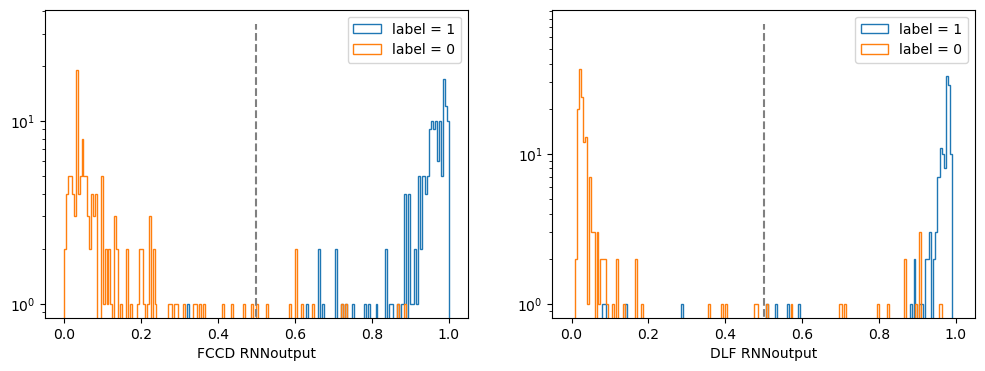

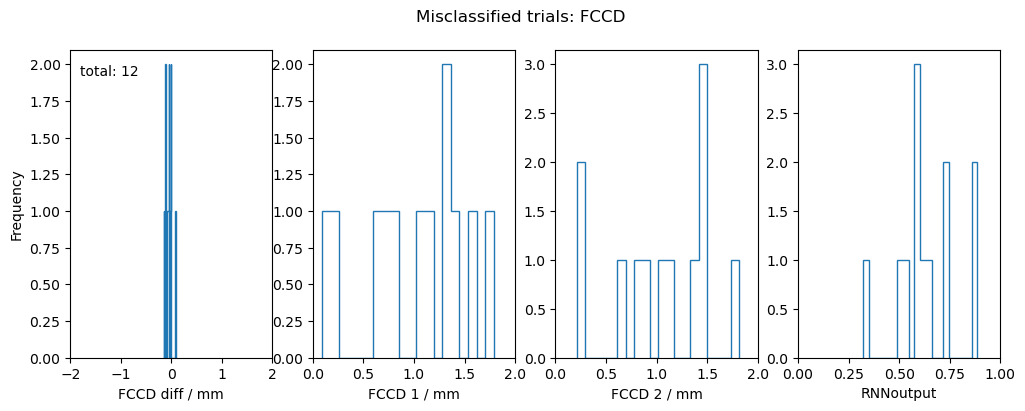

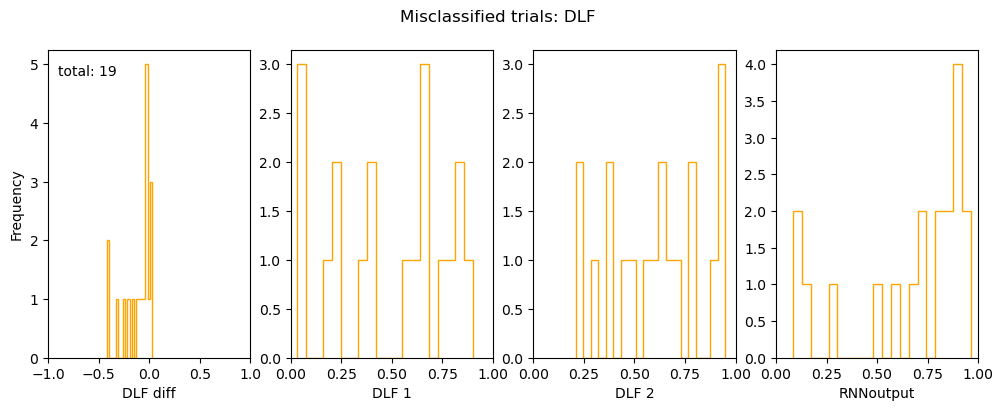

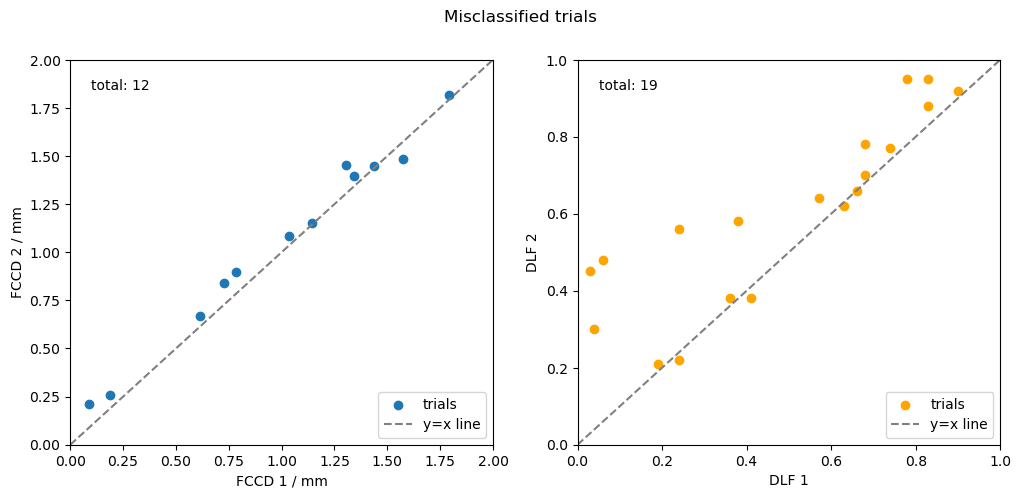

In [18]:
#testing
accuracies_fulldataset = test_RNN(RNNclassifier_fulldataset, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


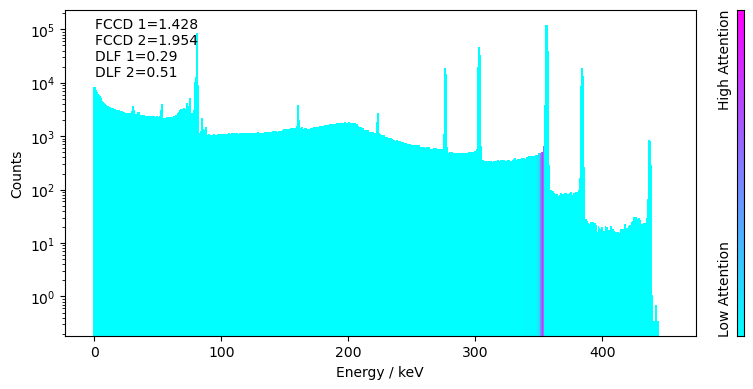

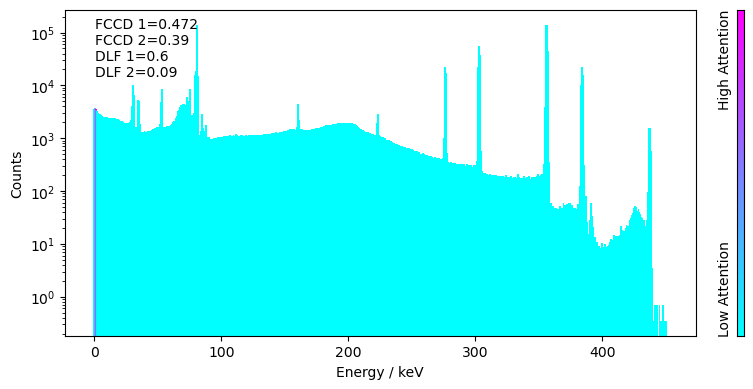

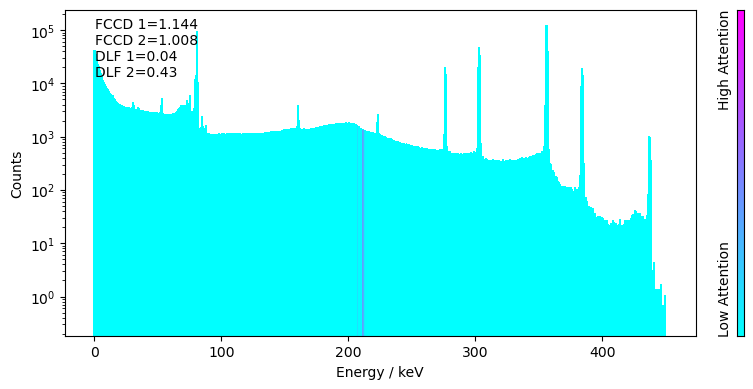

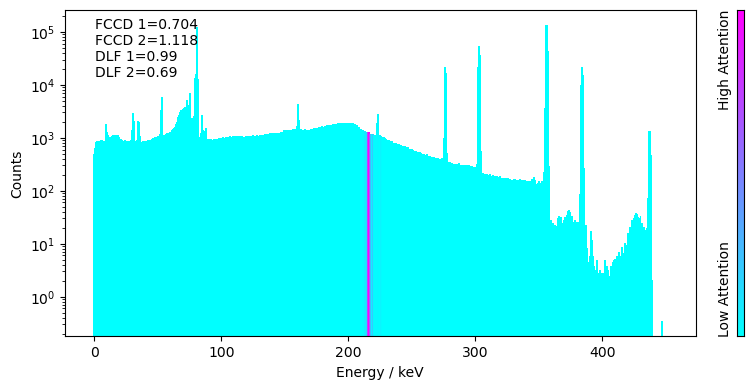

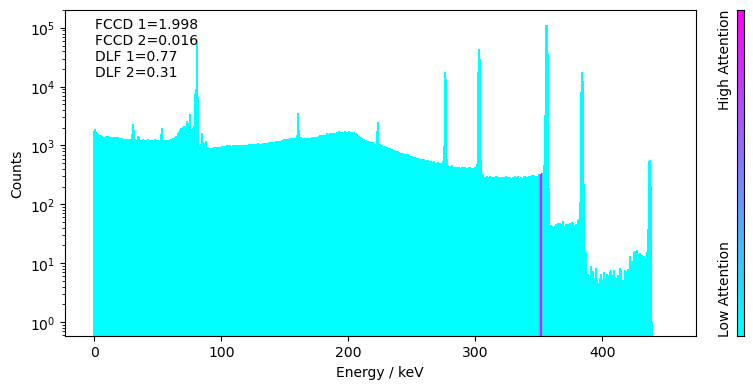

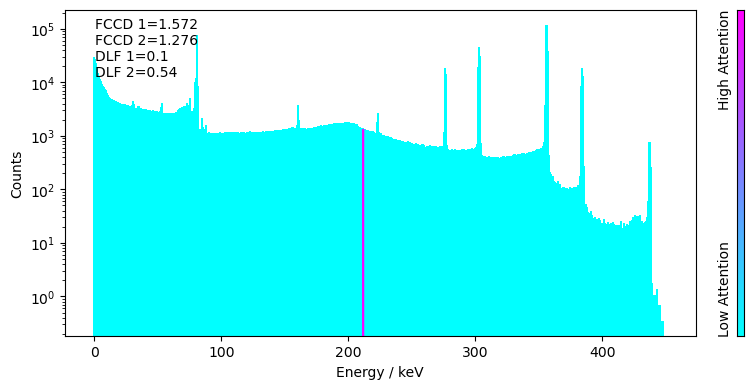

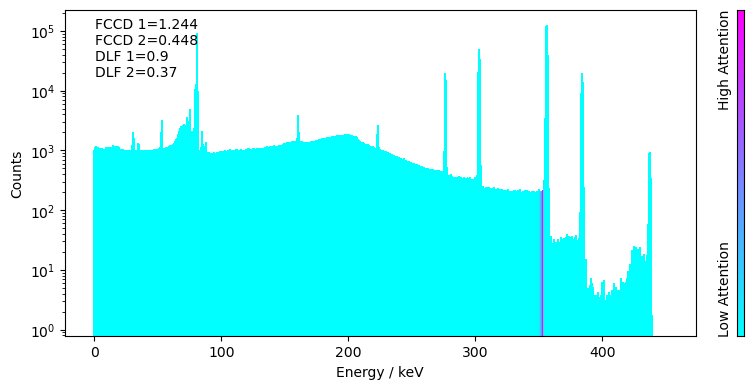

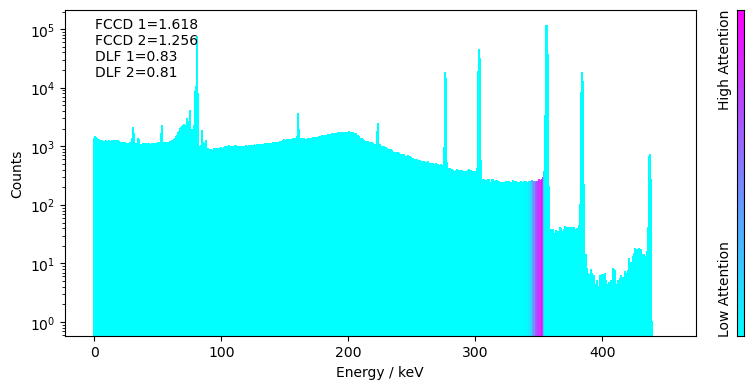

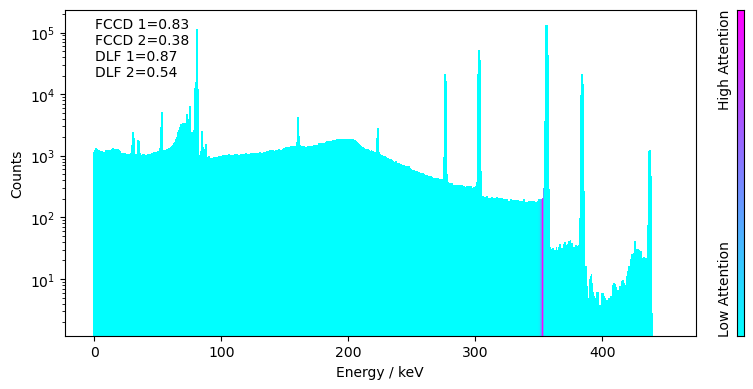

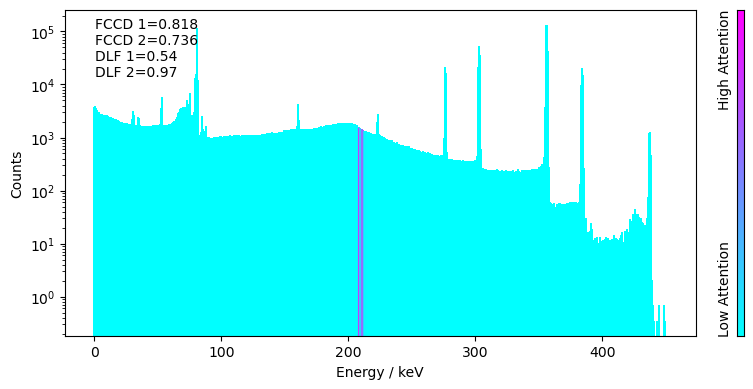

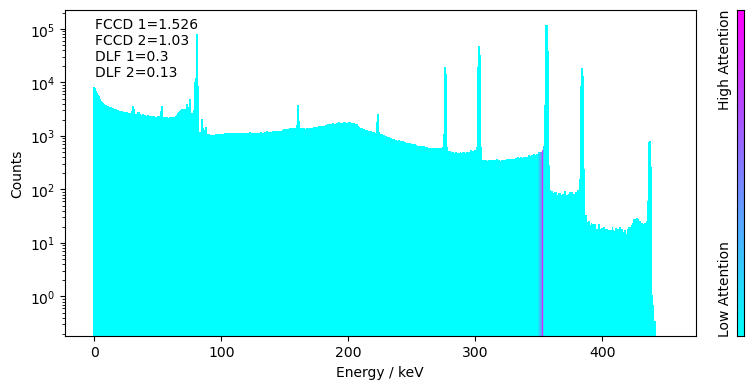

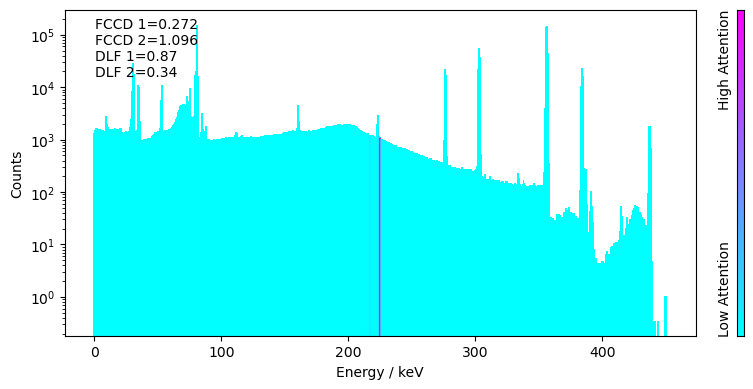

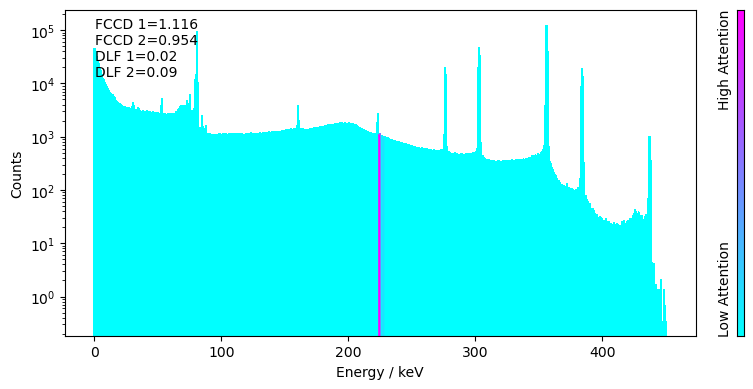

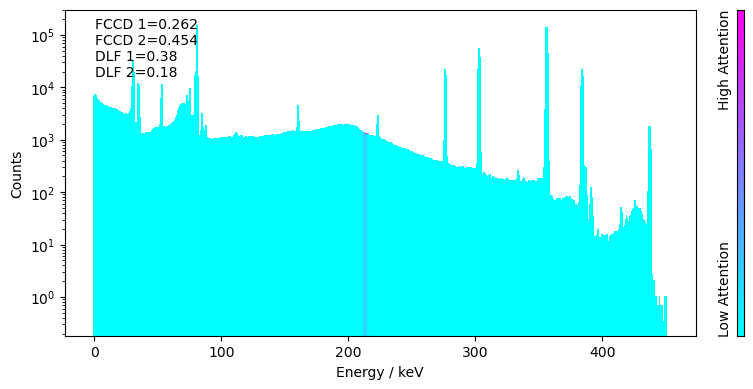

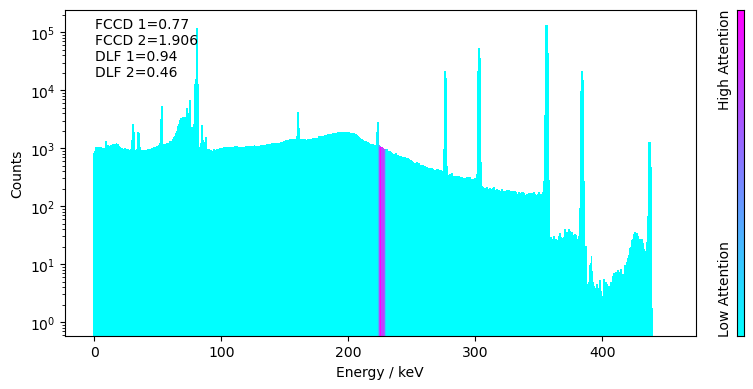

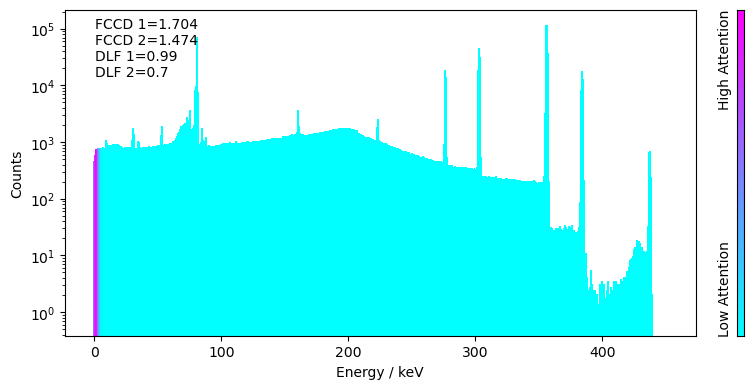

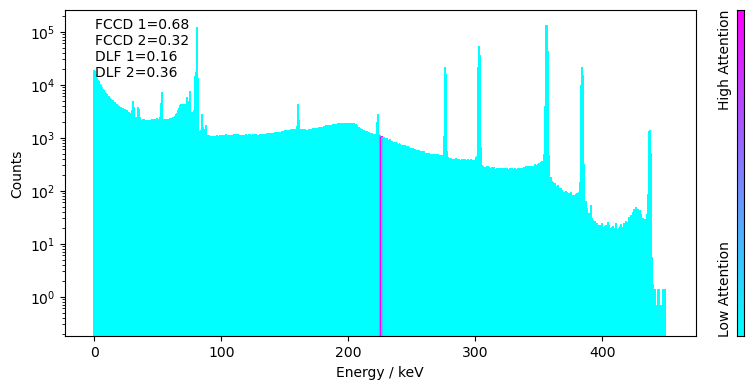

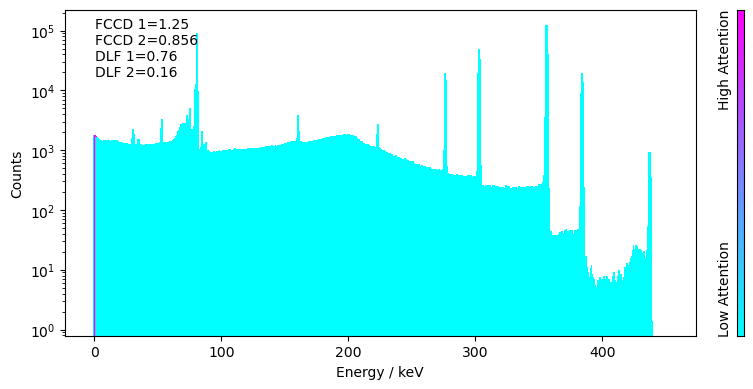

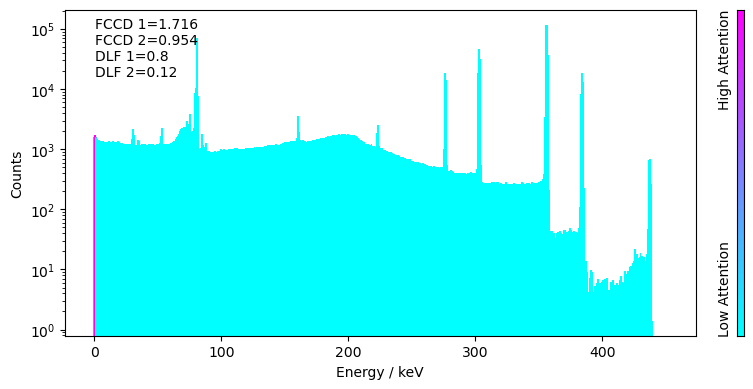

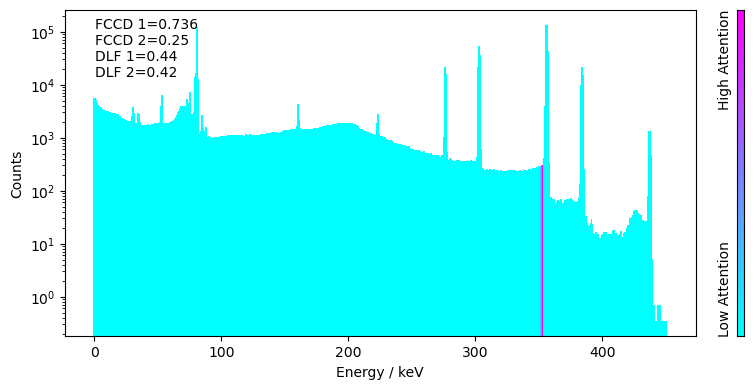

In [19]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")

for a in range(5): 
    
    #Load a test event through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)


    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)

    #     pdf.savefig(fig)
        fig.savefig(pdf, format='pdf') 

pdf.close()
    

# TRAINING 2: restircted dataset - Max FCCD diff = 0.5 mm

Only train on FCCDs with a max diff of 0.5 mm

In [20]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
maxFCCDdiff = 0.5
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

In [21]:
#load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.42it/s]

(1000, 900)


## Training - DO NOT RERUN UNLESS NECESARRY

In [ ]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)


In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing - on maxFCCDdiff=0.5mm

In [22]:
# Load saved model
RNNclassifier_maxFCCDdiff0_5mm = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_5mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_5mm.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

 12%|████████▊                                                                | 9/75 [00:00<00:06, 10.10it/s]

DLF and FCCD misclassified for same trial:
j:  7 , i:  1
FCCD1:  0.01 , FCCD2:  0.038 , FCCD_diff:  -0.027999999999999997 , RNNoutput:  0.89968145
DLF1:  0.04 , DLF2:  0.24 , DLF_diff:  -0.19999999999999998 , RNNoutput:  0.95978934


 47%|█████████████████████████████████▌                                      | 35/75 [00:03<00:03, 11.23it/s]

DLF and FCCD misclassified for same trial:
j:  32 , i:  1
FCCD1:  0.024 , FCCD2:  0.056 , FCCD_diff:  -0.032 , RNNoutput:  0.89211434
DLF1:  0.38 , DLF2:  0.42 , DLF_diff:  -0.03999999999999998 , RNNoutput:  0.9627301


100%|████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00,  9.87it/s]


FCCD accuracies: 
total:  300
TP:  153
FP:  15
TN:  125
FN:  7
accuracy:  0.9266666666666666
precision:  0.9107142857142857
recall:  0.95625

DLF accuracies: 
total:  300
TP:  145
FP:  13
TN:  137
FN:  5
accuracy:  0.94
precision:  0.9177215189873418
recall:  0.9666666666666667
Total # misclassified trials FCCD:  22  / 300
Total # misclassified trials DLF:  18  / 300


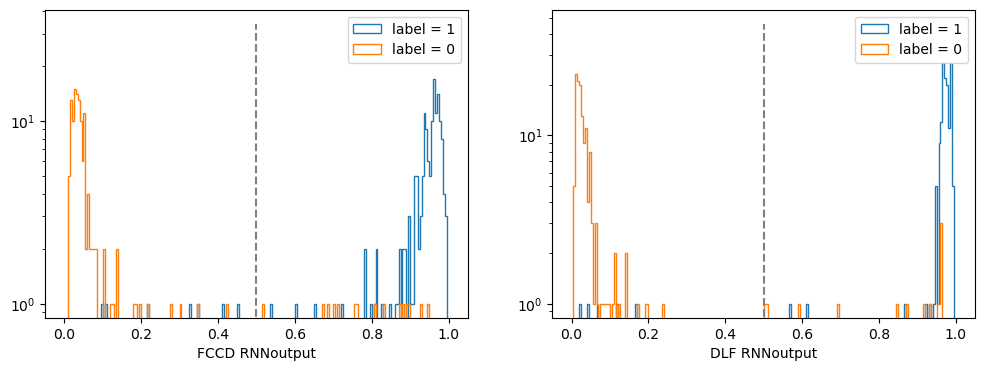

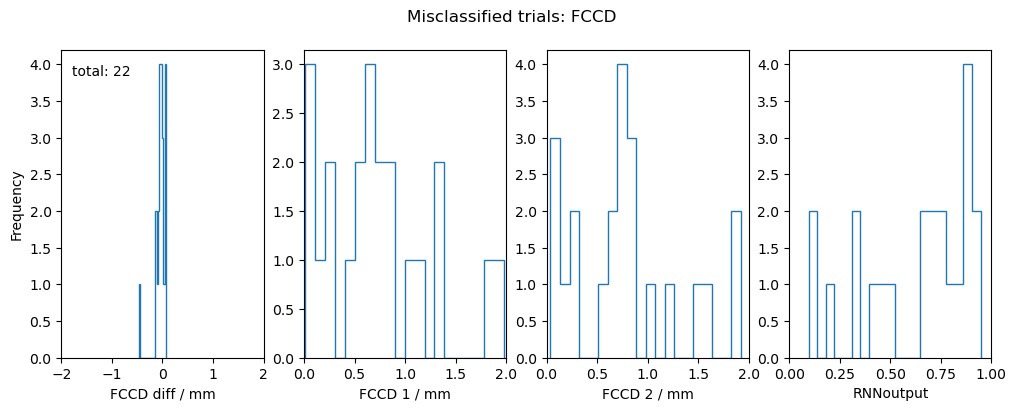

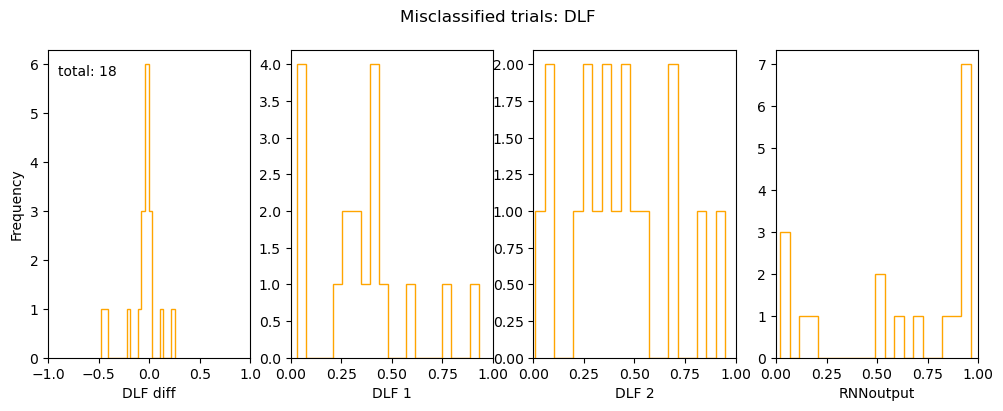

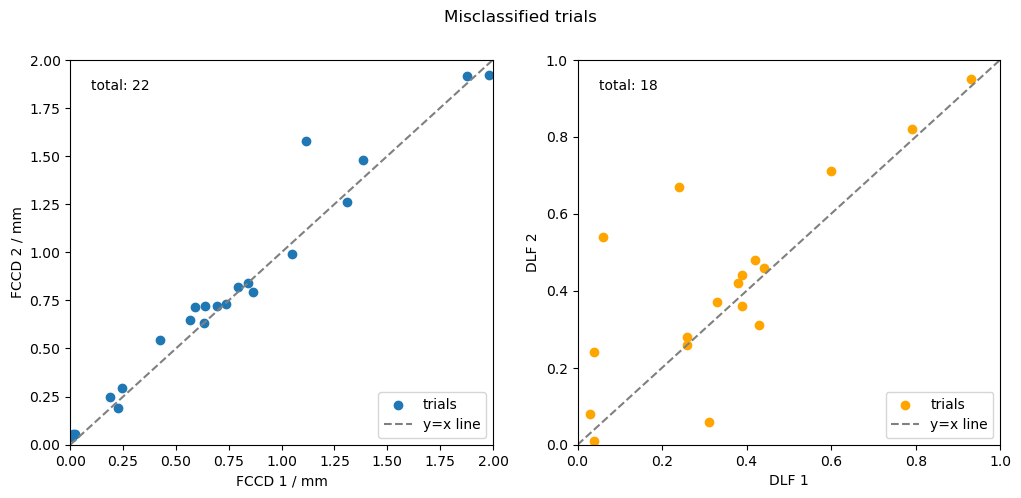

In [25]:
#testing
accuracies_maxFCCDdiff0_5mm = test_RNN(RNNclassifier_maxFCCDdiff0_5mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


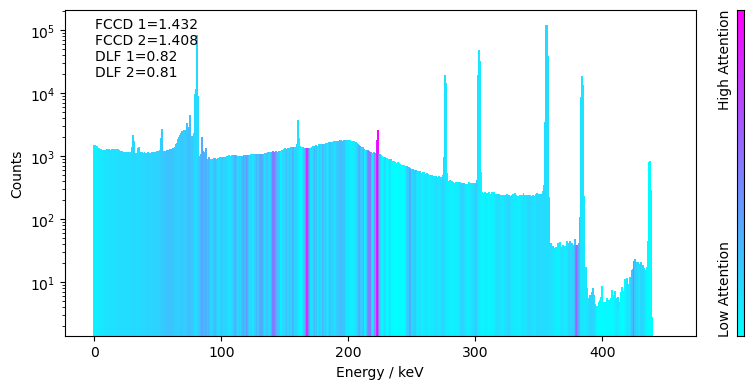

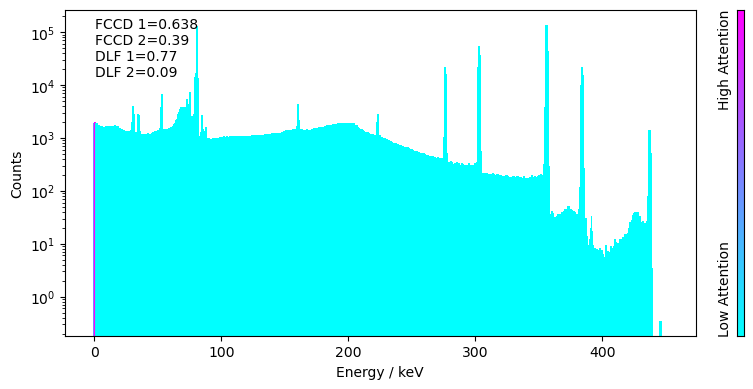

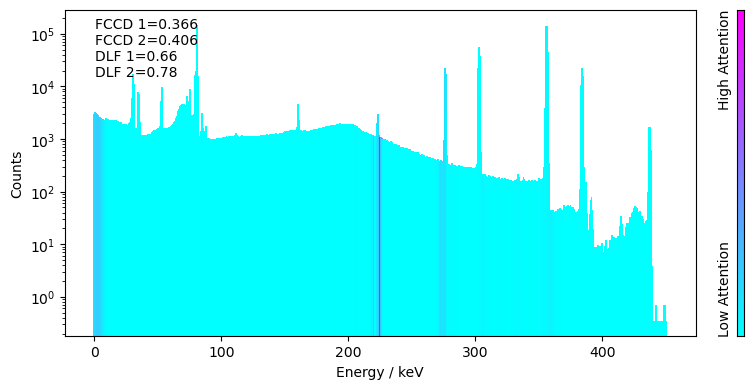

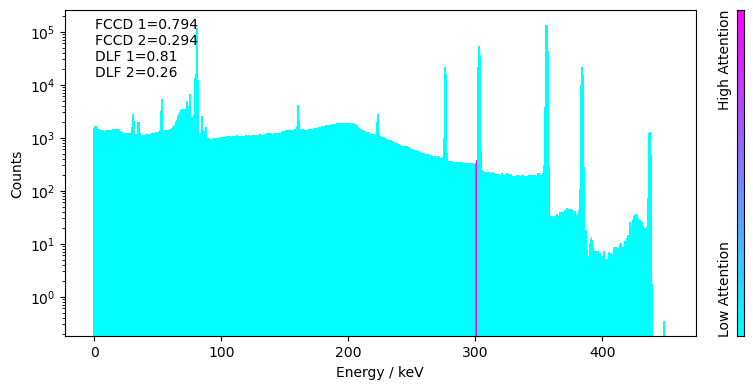

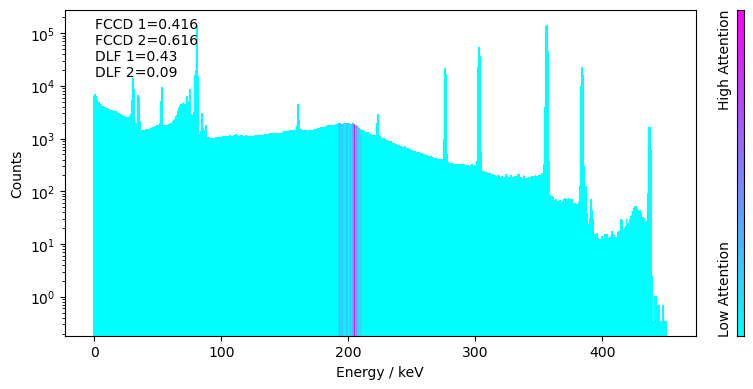

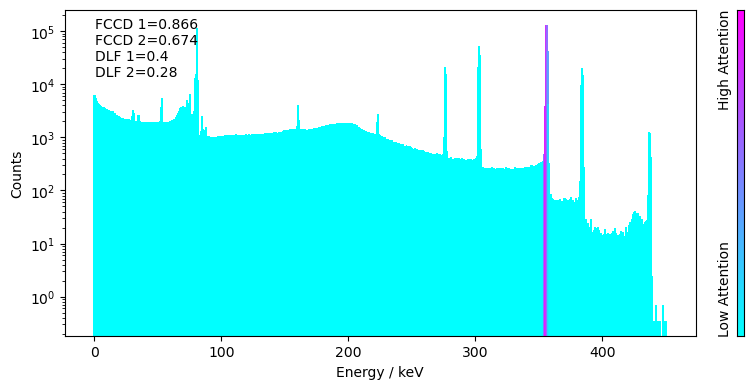

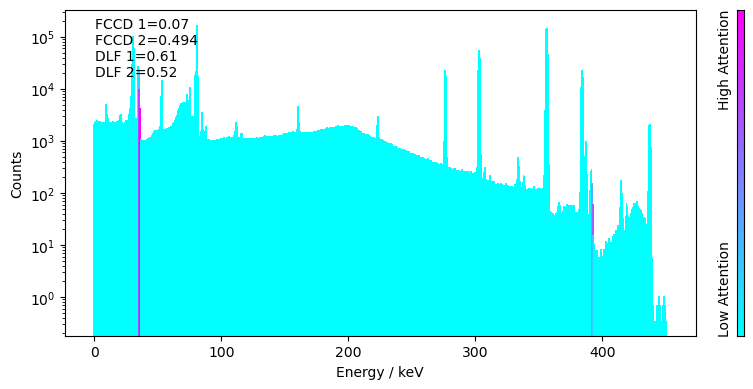

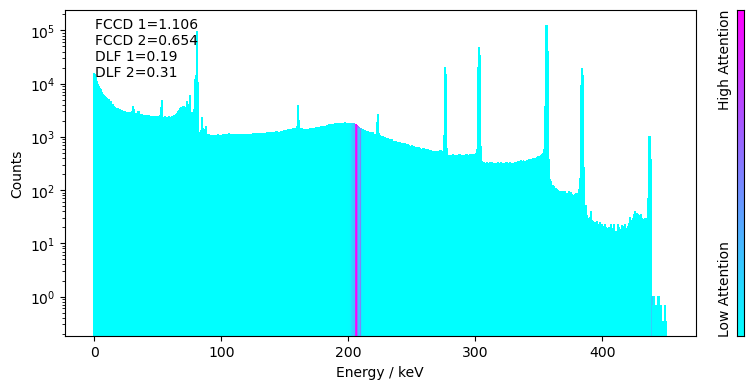

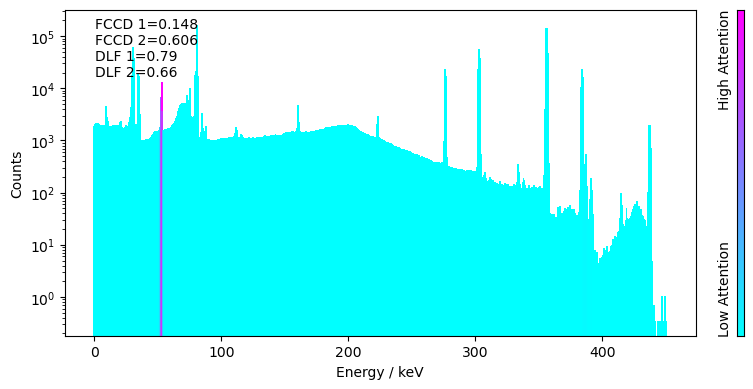

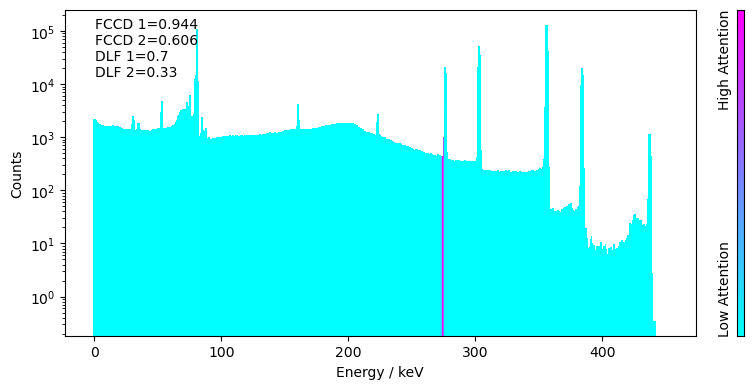

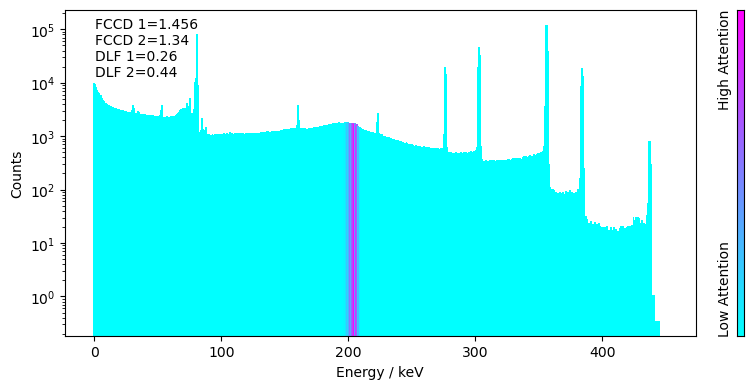

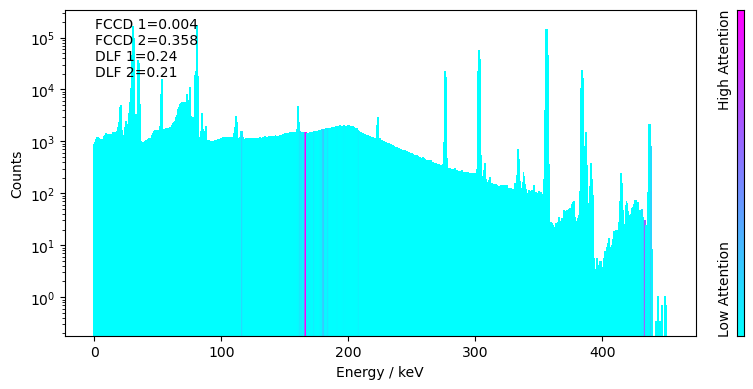

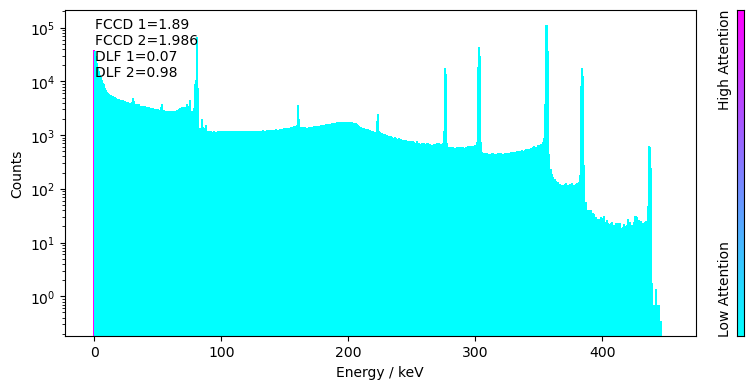

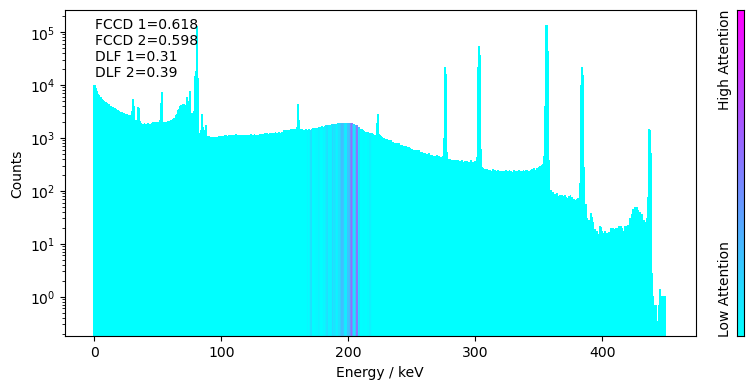

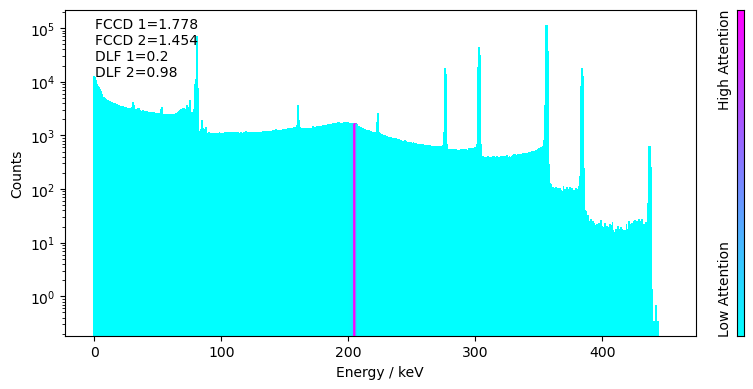

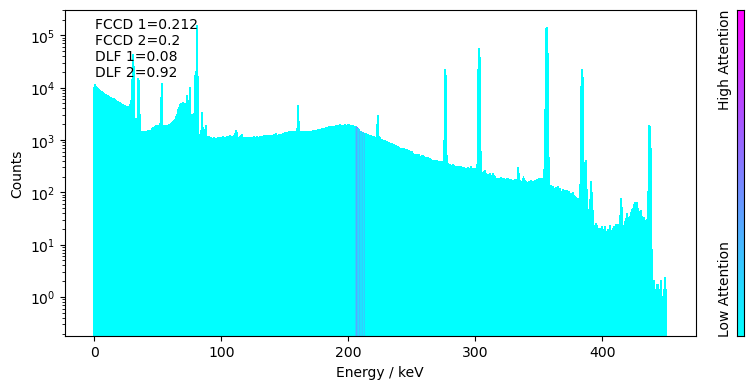

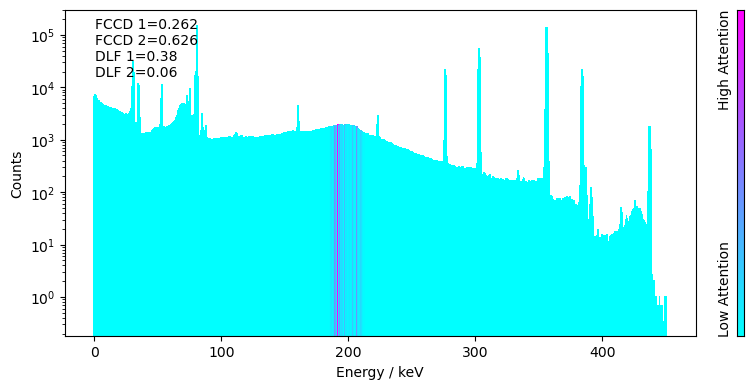

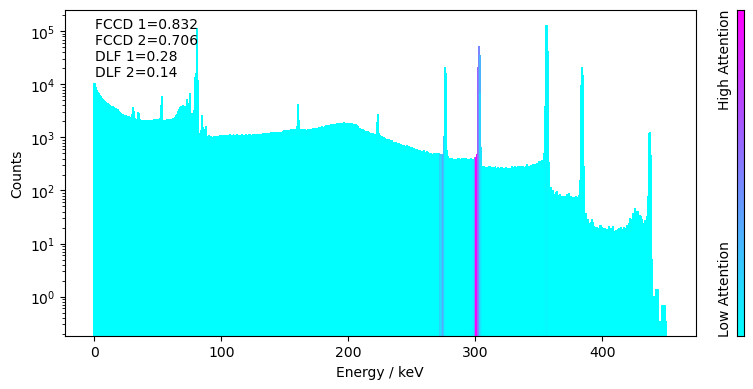

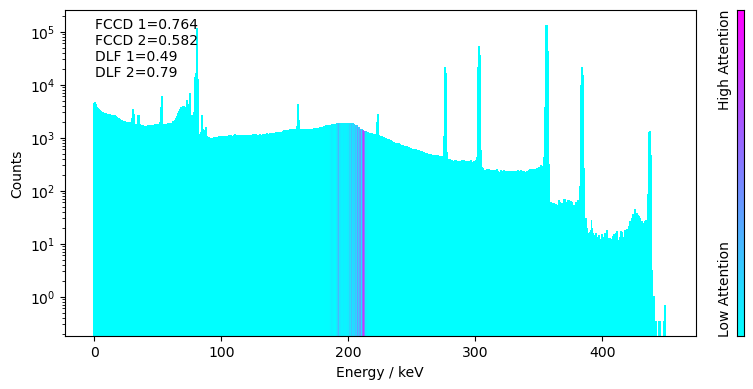

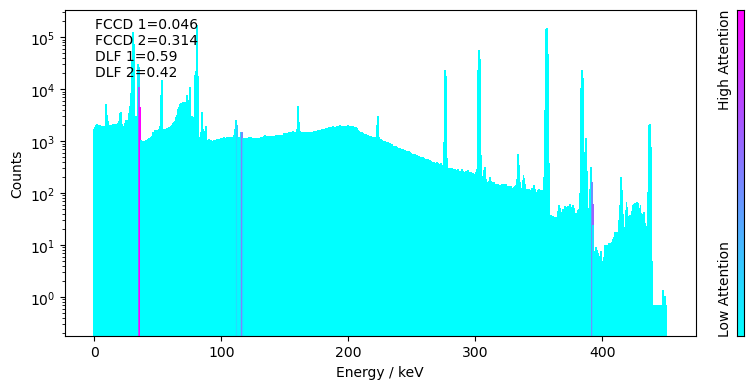

In [23]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

## Testing - on full dataset

In [24]:
train_loader, test_loader, dataset = load_data(BATCH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.56it/s]


(1000, 900)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.17it/s]


FCCD accuracies: 
total:  300
TP:  144
FP:  7
TN:  143
FN:  6
accuracy:  0.9566666666666667
precision:  0.9536423841059603
recall:  0.96

DLF accuracies: 
total:  300
TP:  137
FP:  13
TN:  142
FN:  8
accuracy:  0.93
precision:  0.9133333333333333
recall:  0.9448275862068966
Total # misclassified trials FCCD:  13  / 300
Total # misclassified trials DLF:  21  / 300


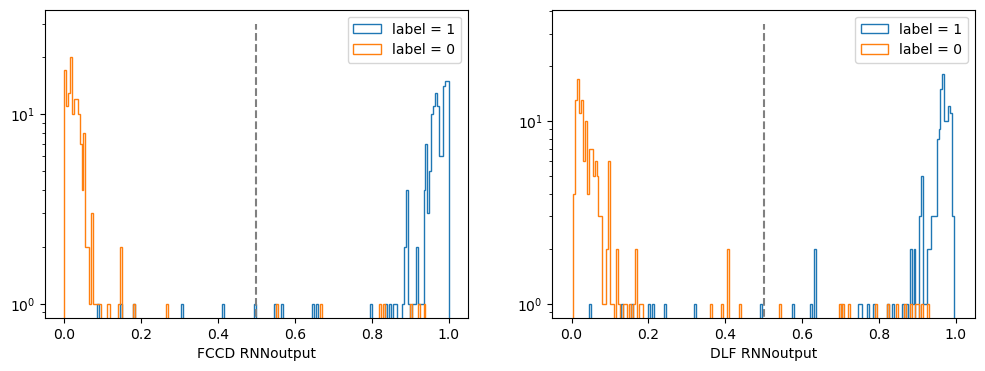

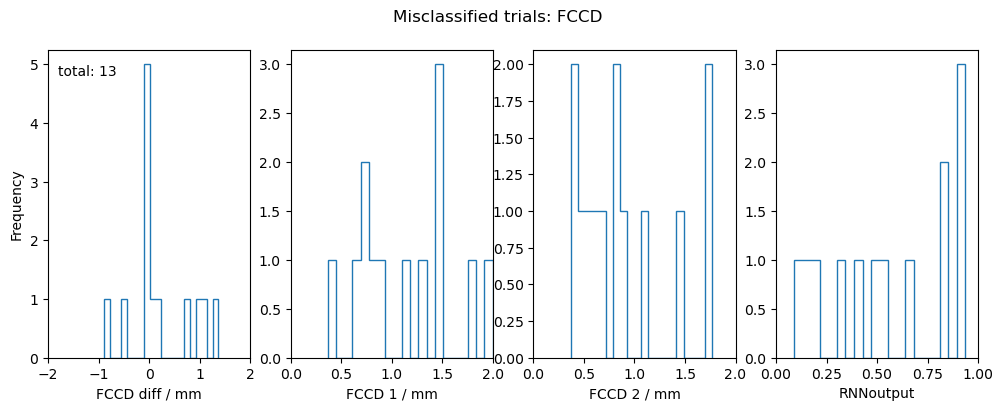

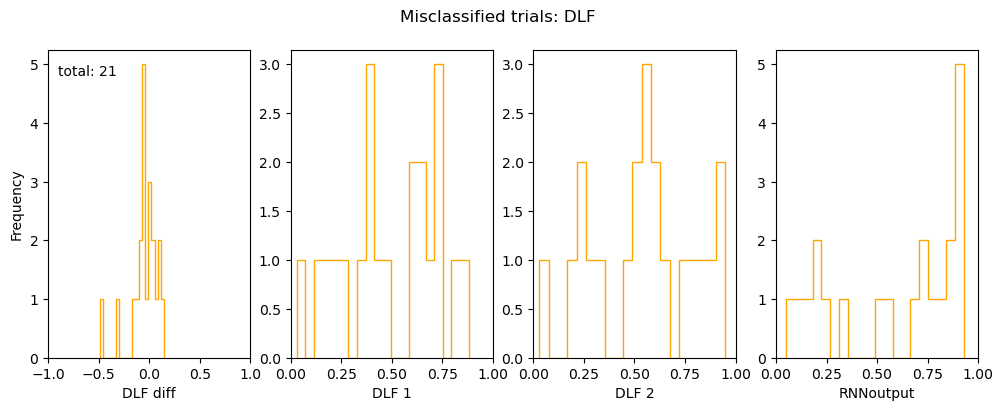

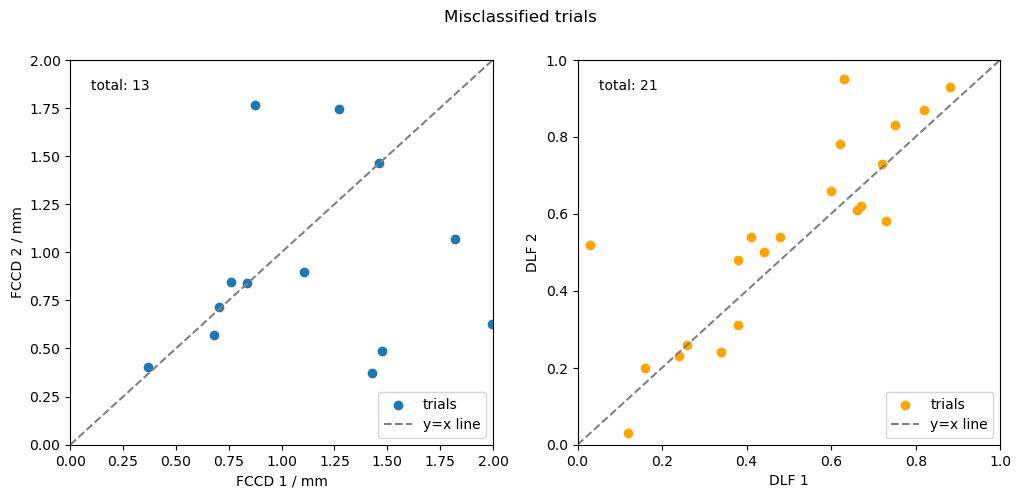

In [25]:
#testing
accuracies_maxFCCDdiff0_5mm = test_RNN(RNNclassifier_maxFCCDdiff0_5mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True, train_restricted_test_fulldataset = True)


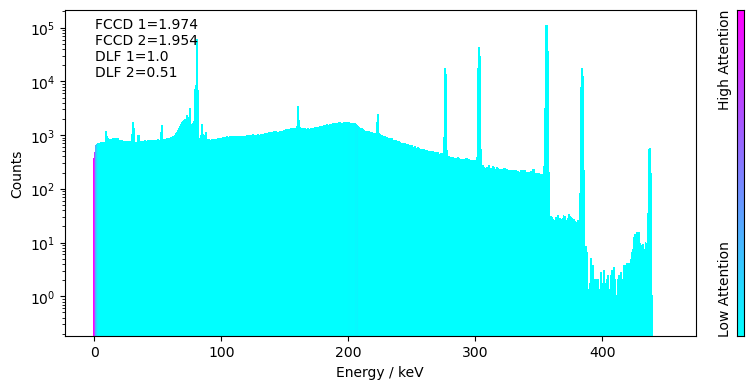

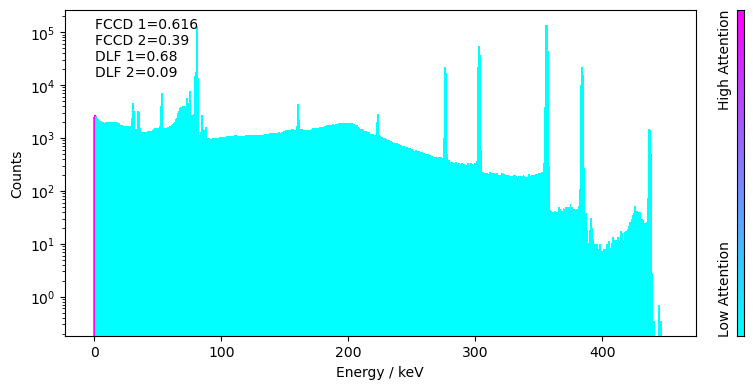

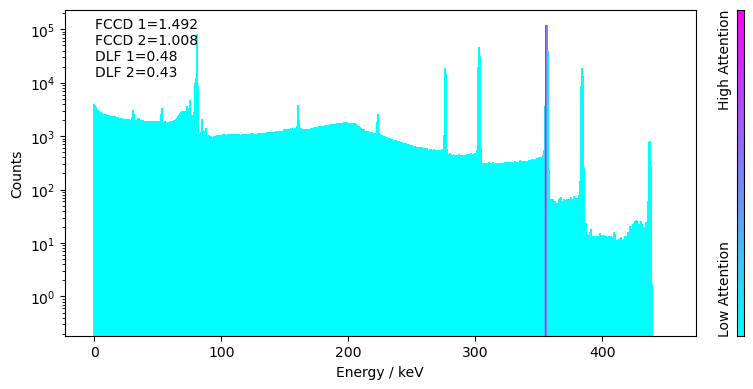

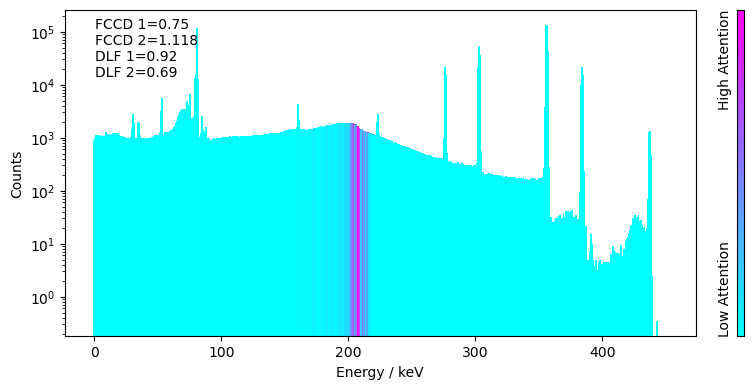

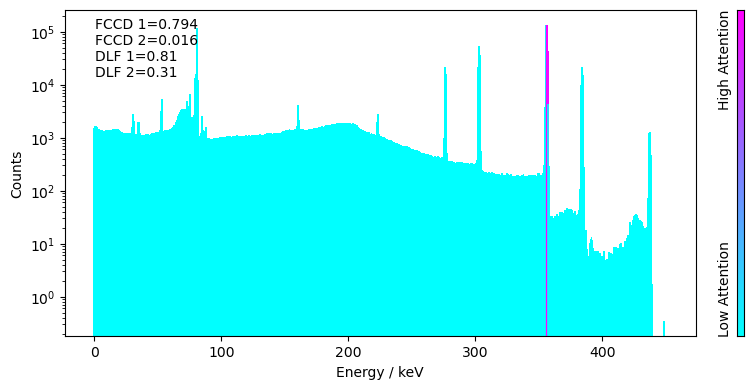

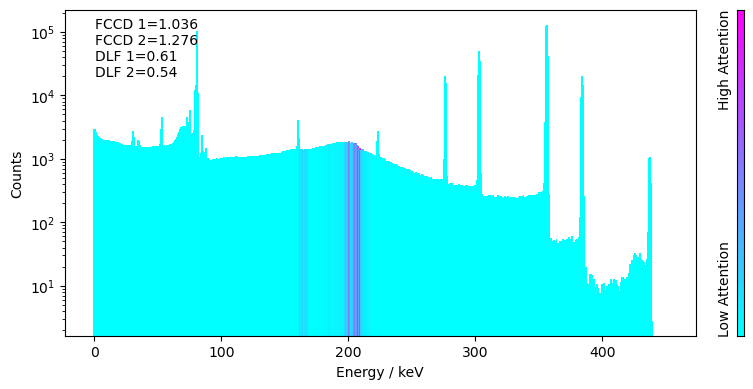

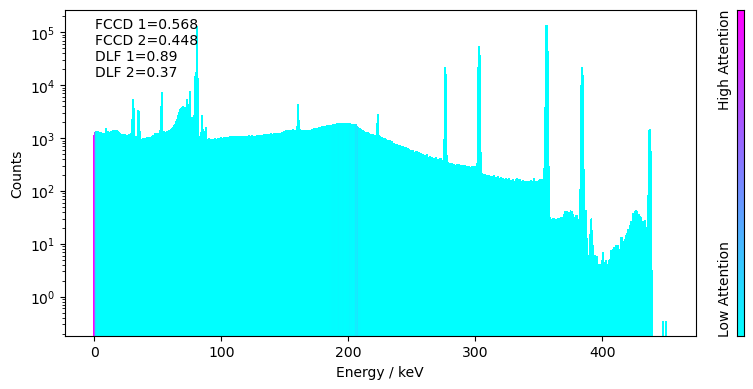

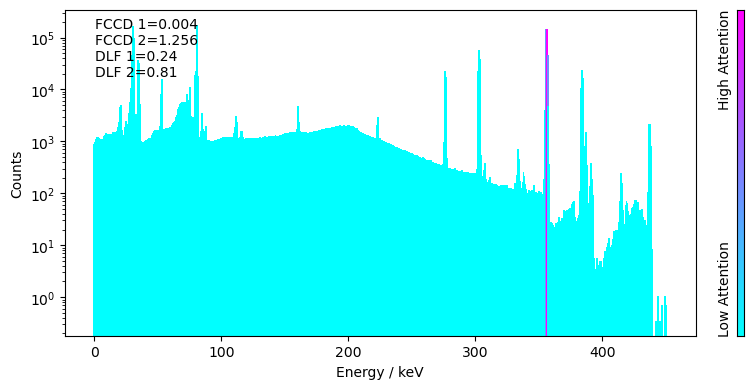

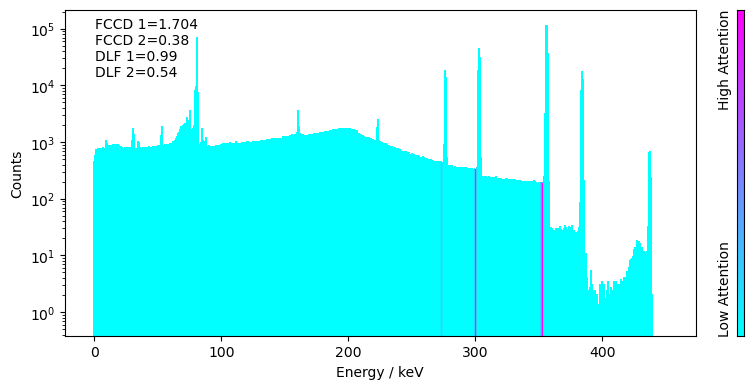

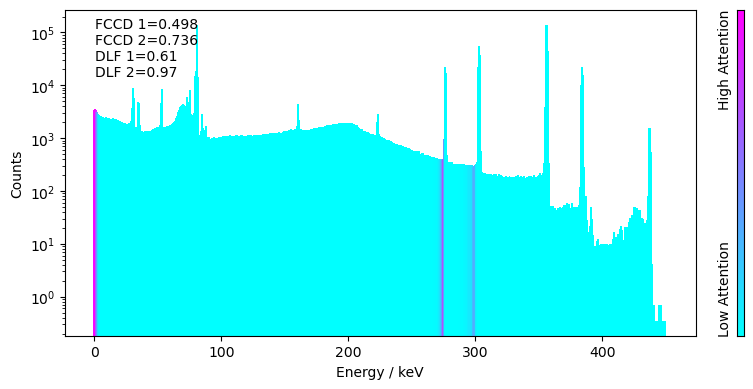

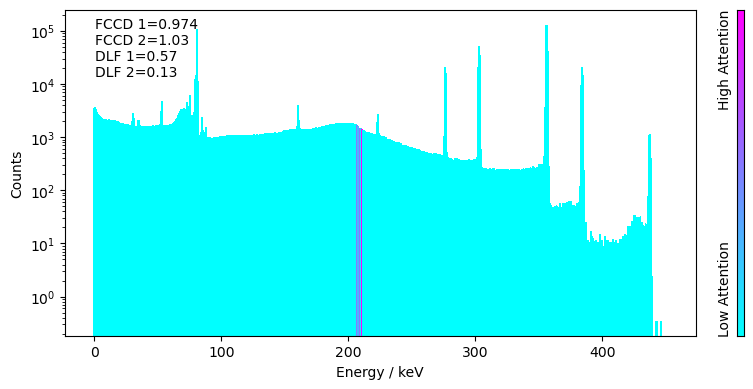

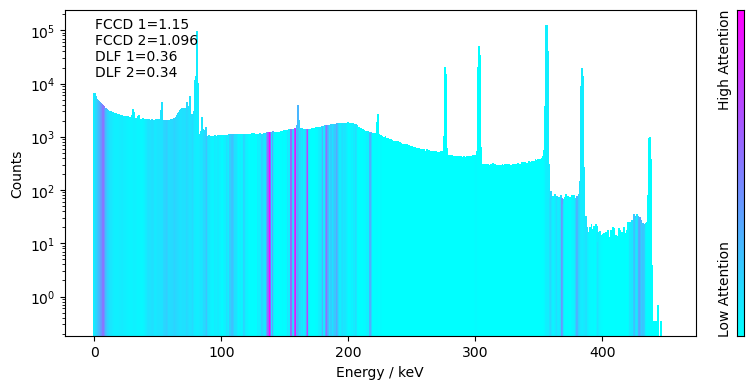

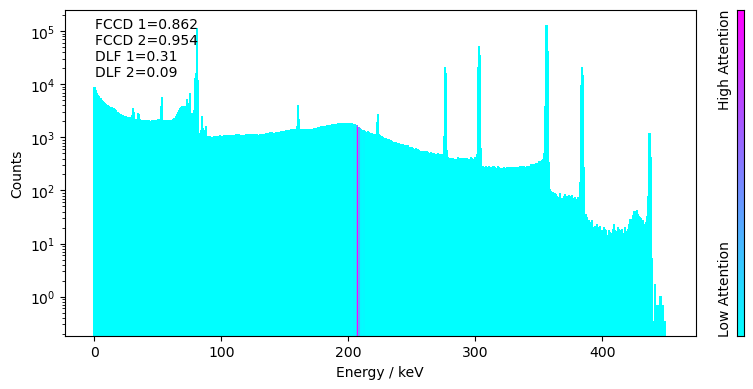

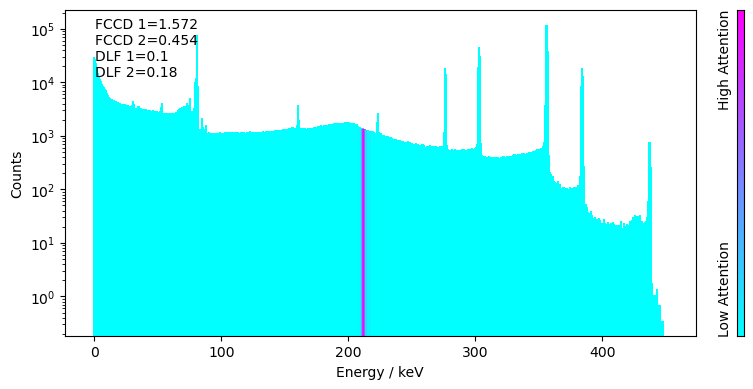

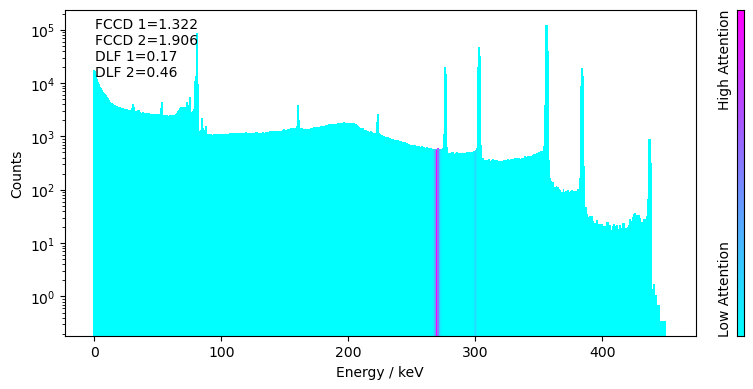

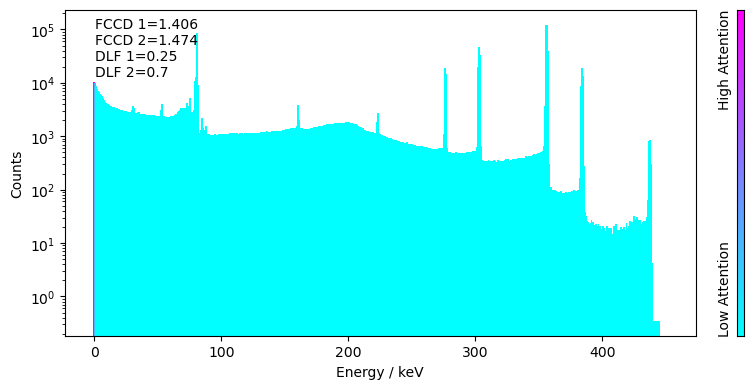

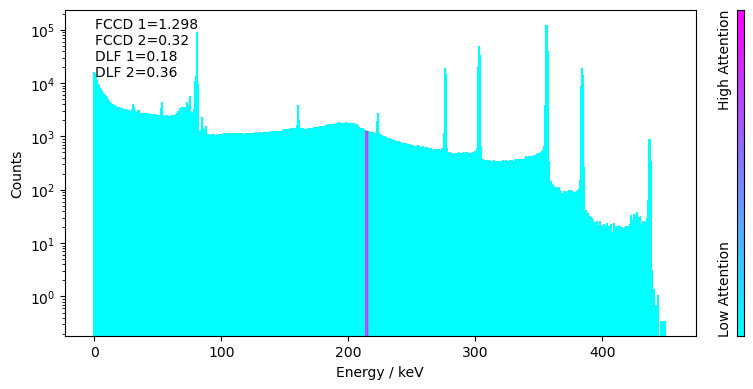

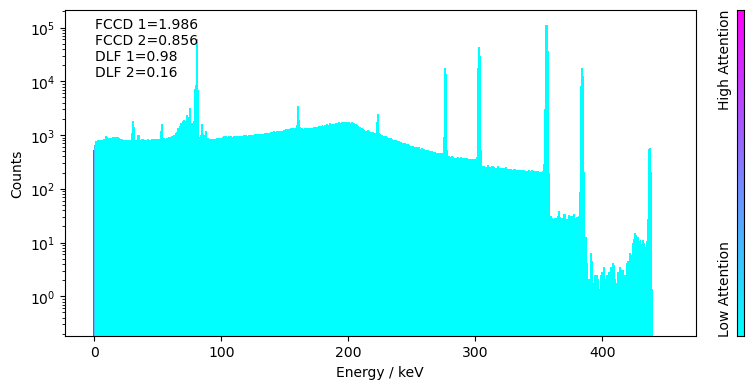

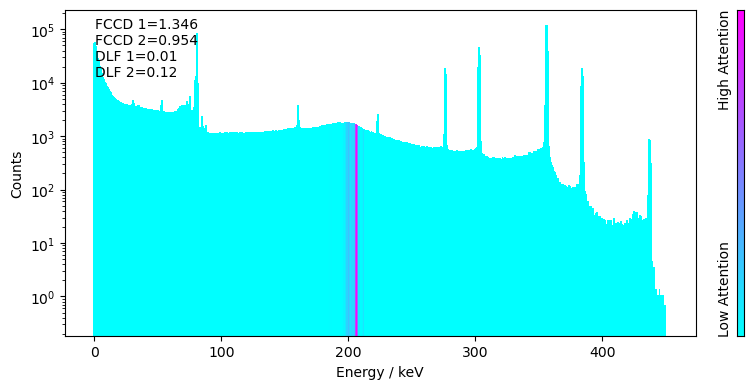

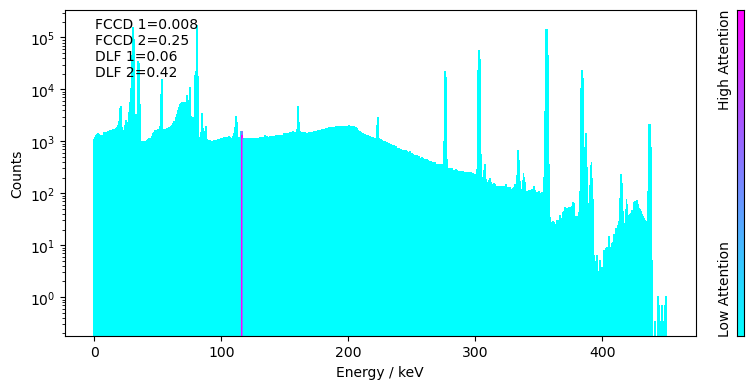

In [26]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention_fulldataset.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# TRAINING 3: restircted dataset - Max FCCD diff = 0.25 mm

Only train on FCCDs with a max diff of 0.25 mm

In [27]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
maxFCCDdiff = 0.25
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm"

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

In [28]:
#load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.81it/s]

(1000, 900)


## Training - DO NOT RERUN UNLESS NECESARRY

In [ ]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)

In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing - on maxFCCDdiff=0.25mm

In [29]:
# Load saved model
RNNclassifier_maxFCCDdiff0_25mm = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_25mm.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_25mm.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

 57%|███████████████████████████████████████████████████                                      | 43/75 [00:04<00:02, 11.03it/s]

DLF and FCCD misclassified for same trial:
j:  41 , i:  3
FCCD1:  0.532 , FCCD2:  0.62 , FCCD_diff:  -0.08799999999999997 , RNNoutput:  0.73528033
DLF1:  0.29 , DLF2:  0.29 , DLF_diff:  0.0 , RNNoutput:  0.054829843


100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.83it/s]


FCCD accuracies: 
total:  300
TP:  146
FP:  6
TN:  131
FN:  17
accuracy:  0.9233333333333333
precision:  0.9605263157894737
recall:  0.8957055214723927

DLF accuracies: 
total:  300
TP:  154
FP:  3
TN:  137
FN:  6
accuracy:  0.97
precision:  0.9808917197452229
recall:  0.9625
Total # misclassified trials FCCD:  23  / 300
Total # misclassified trials DLF:  9  / 300


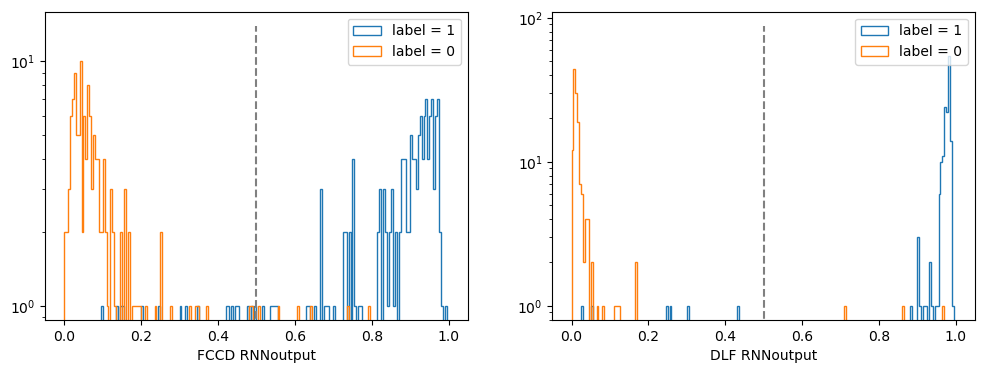

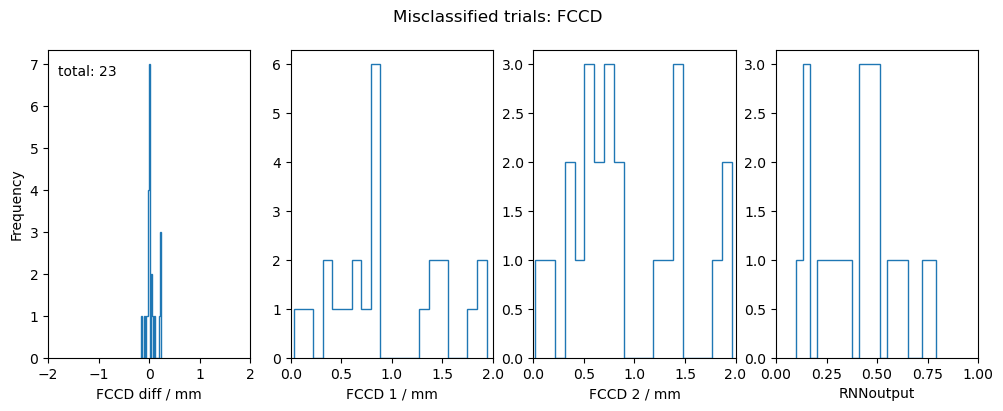

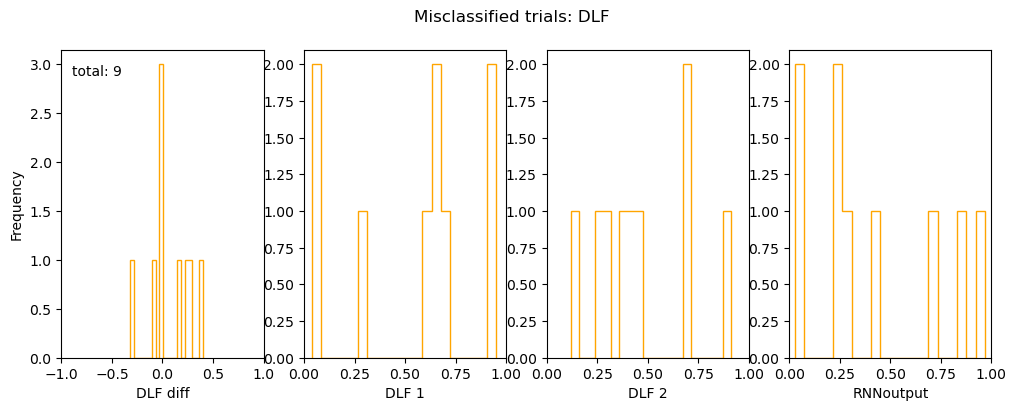

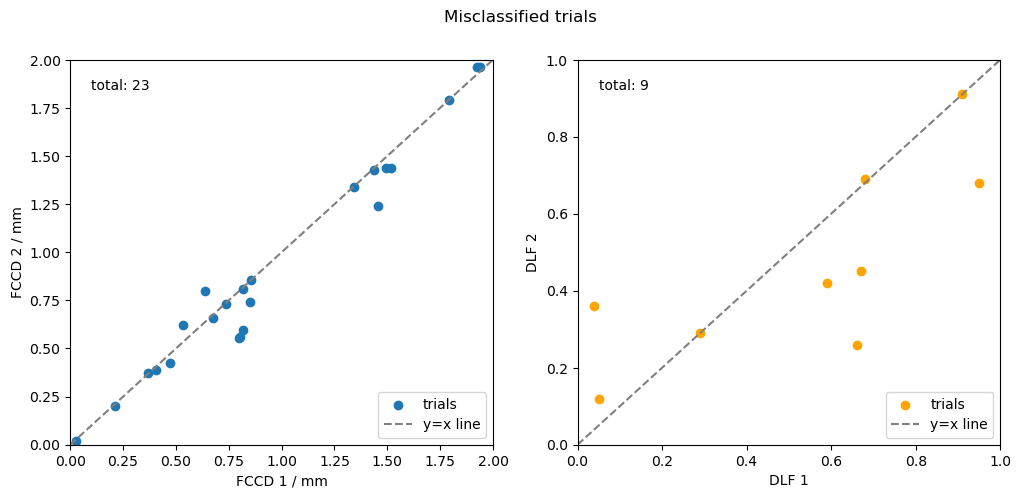

In [30]:
#testing
accuracies_maxFCCDdiff0_25mm = test_RNN(RNNclassifier_maxFCCDdiff0_25mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


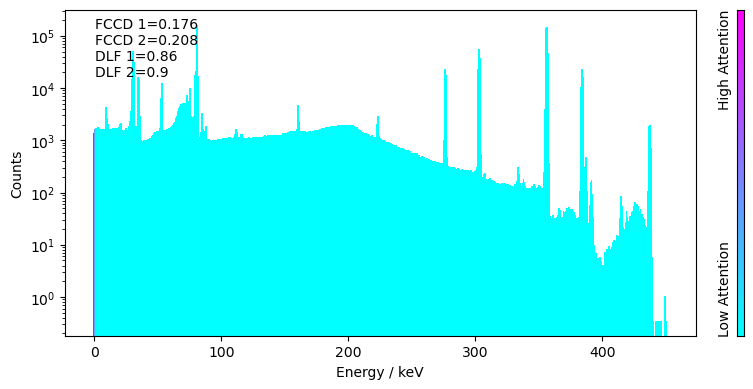

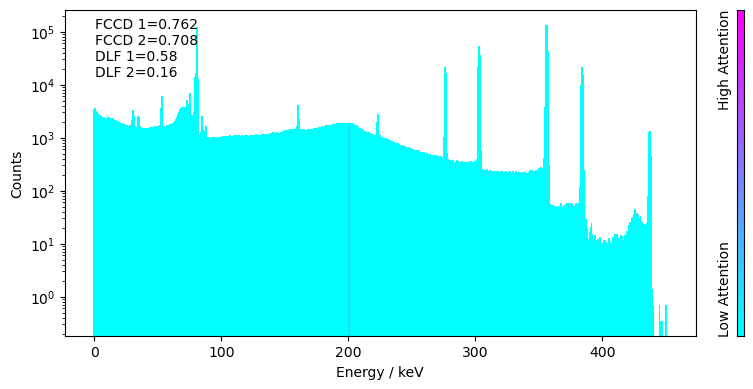

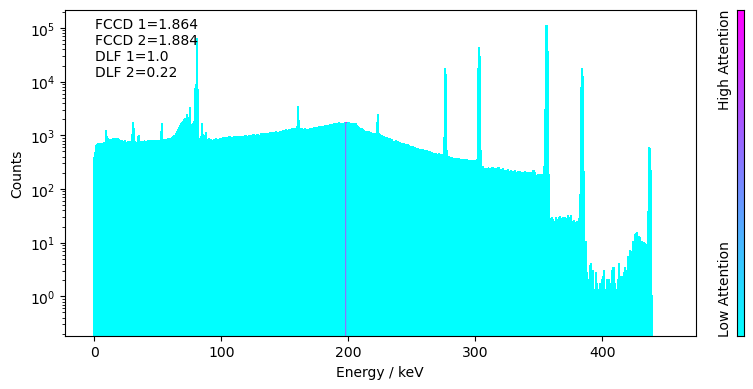

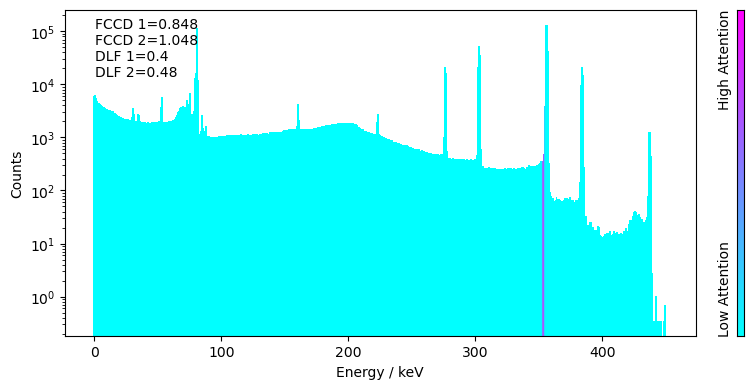

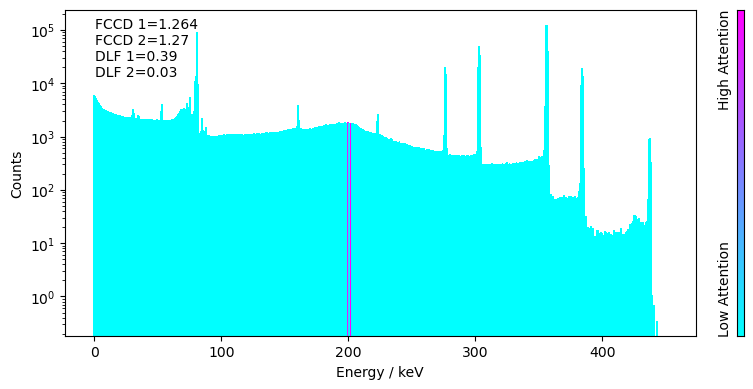

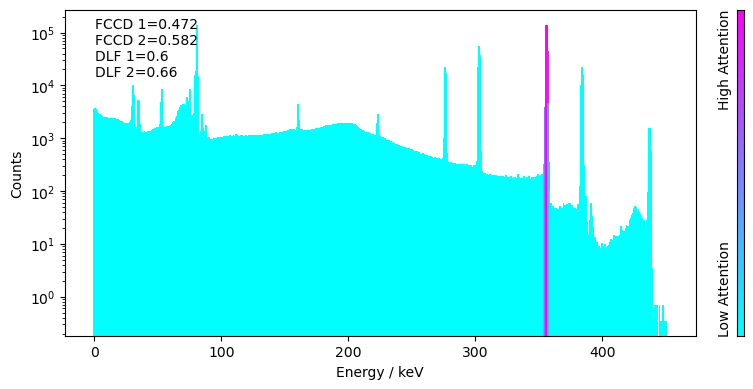

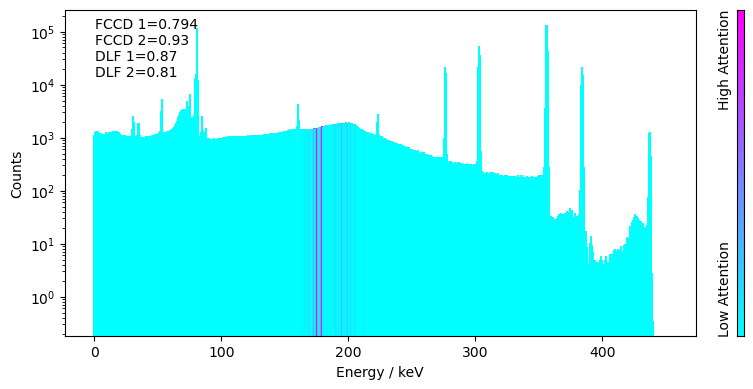

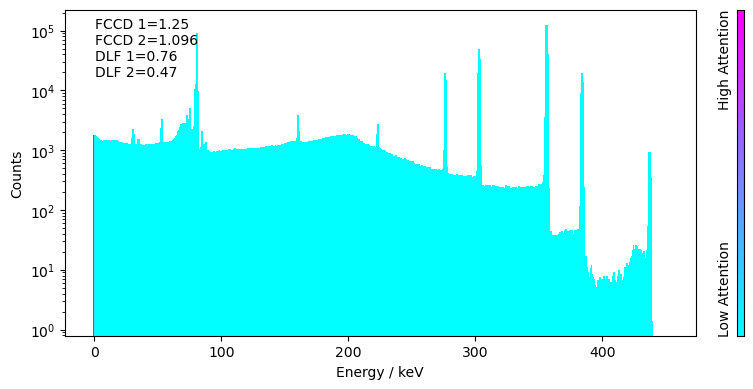

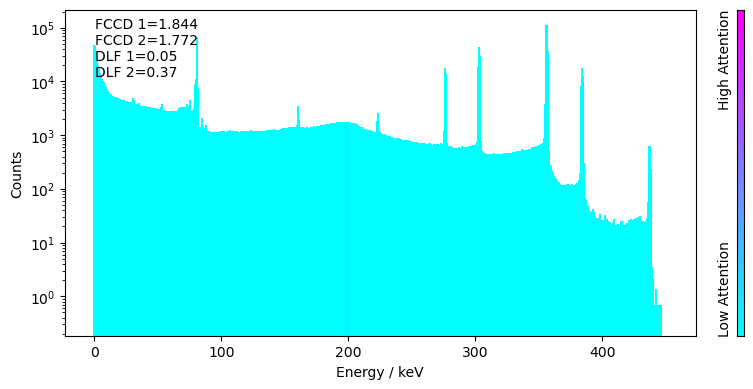

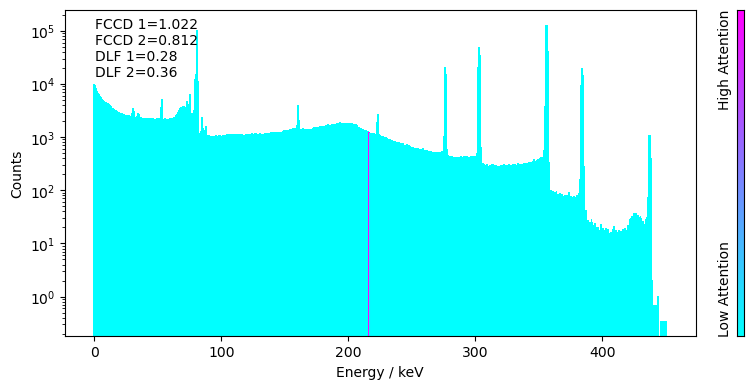

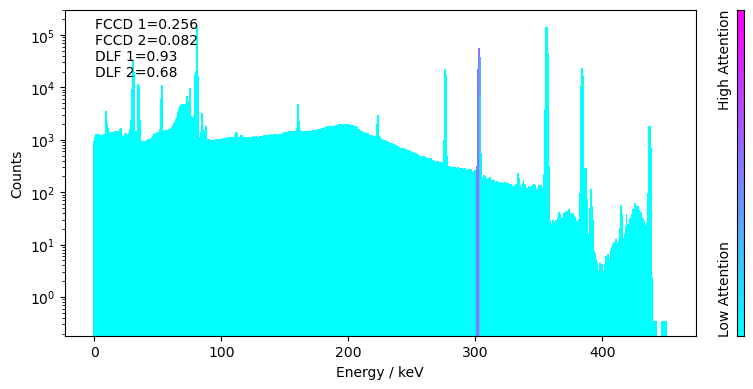

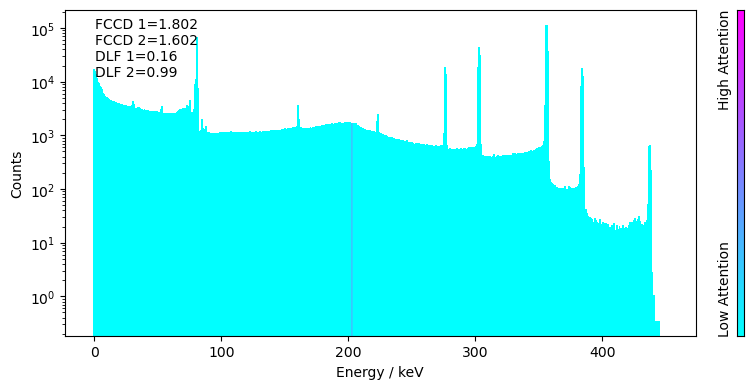

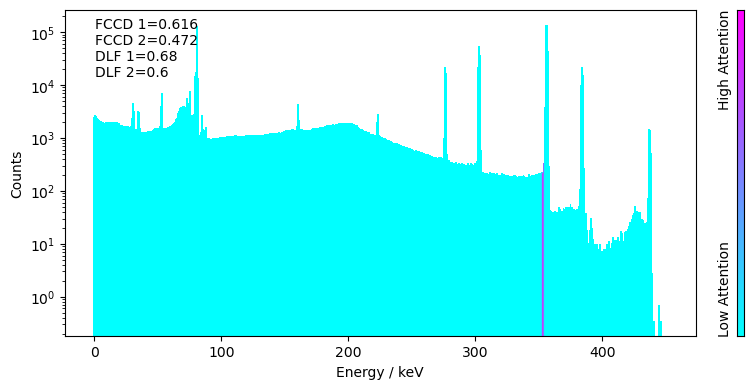

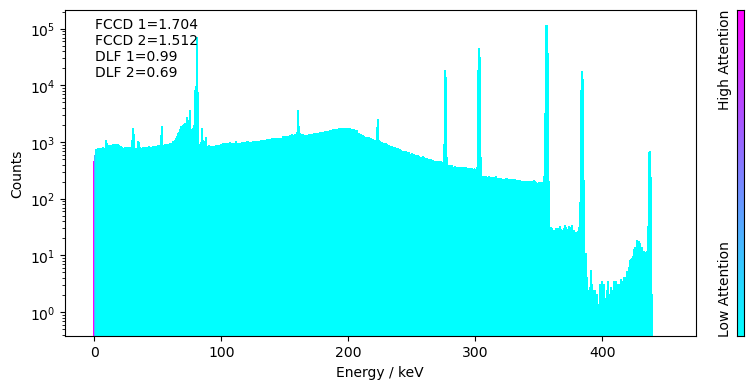

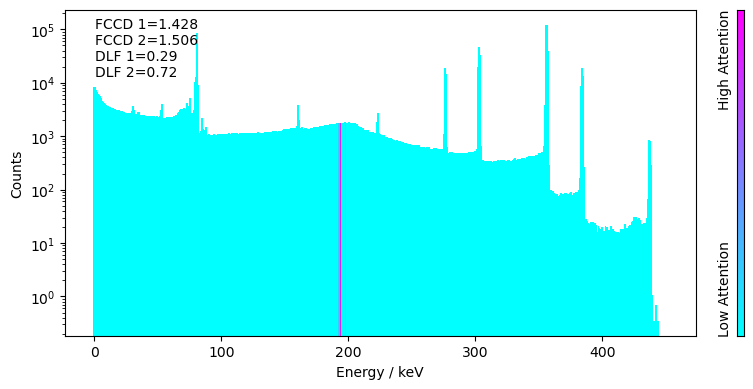

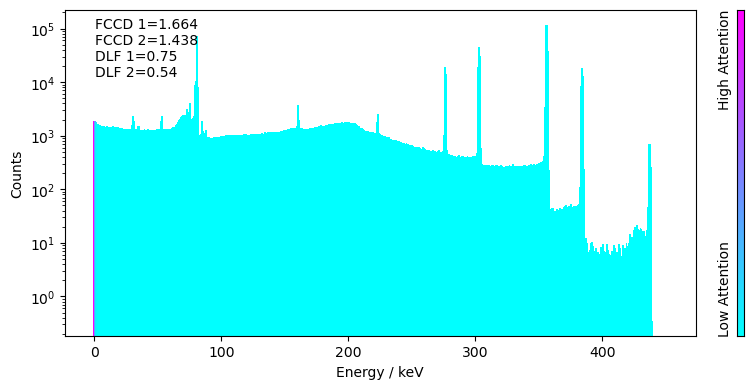

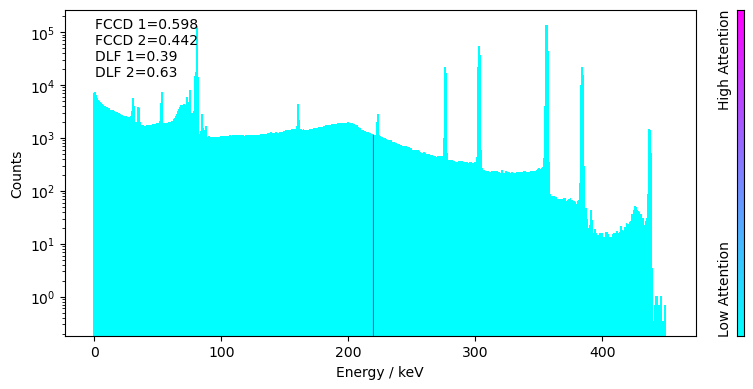

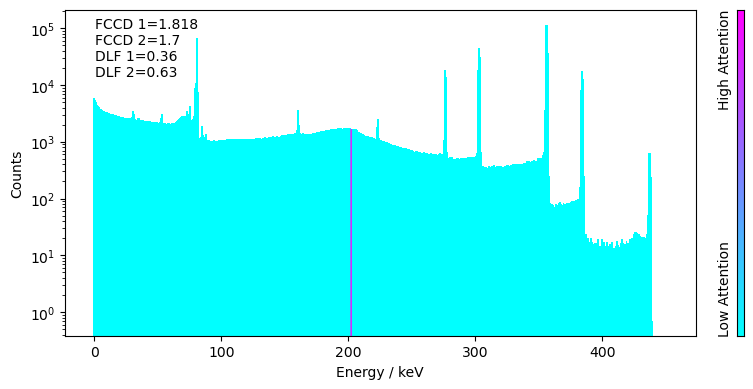

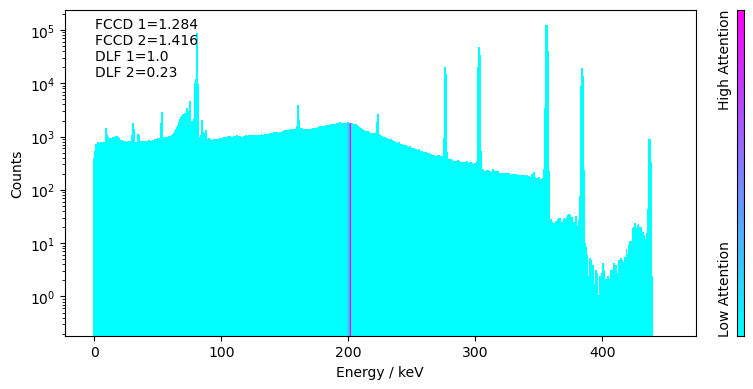

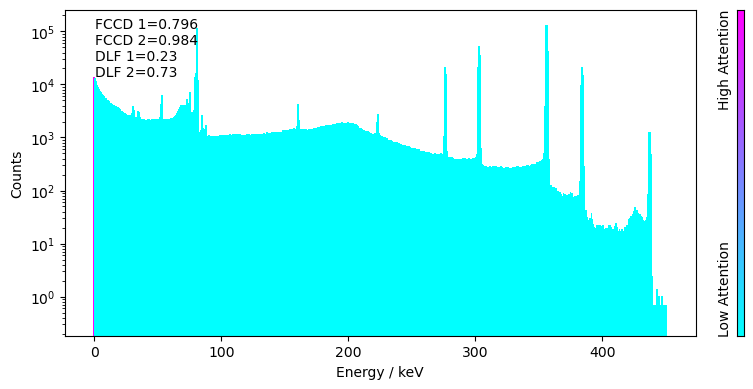

In [31]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

## Testing - on full dataset

In [32]:
train_loader, test_loader, dataset = load_data(BATCH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.68it/s]

(1000, 900)


 13%|███████████▊                                                                             | 10/75 [00:00<00:06, 10.58it/s]

DLF and FCCD misclassified for same trial:
j:  8 , i:  0
FCCD1:  1.544 , FCCD2:  0.358 , FCCD_diff:  1.186 , RNNoutput:  0.2761037
DLF1:  0.42 , DLF2:  0.21 , DLF_diff:  0.21 , RNNoutput:  0.37397522


 69%|█████████████████████████████████████████████████████████████▋                           | 52/75 [00:04<00:02, 11.05it/s]

DLF and FCCD misclassified for same trial:
j:  49 , i:  2
FCCD1:  0.454 , FCCD2:  1.964 , FCCD_diff:  -1.51 , RNNoutput:  0.6958799
DLF1:  0.18 , DLF2:  0.16 , DLF_diff:  0.01999999999999999 , RNNoutput:  0.2761285


100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.90it/s]


FCCD accuracies: 
total:  300
TP:  128
FP:  23
TN:  122
FN:  27
accuracy:  0.8333333333333334
precision:  0.847682119205298
recall:  0.8258064516129032

DLF accuracies: 
total:  300
TP:  120
FP:  18
TN:  139
FN:  23
accuracy:  0.8633333333333333
precision:  0.8695652173913043
recall:  0.8391608391608392
Total # misclassified trials FCCD:  50  / 300
Total # misclassified trials DLF:  41  / 300


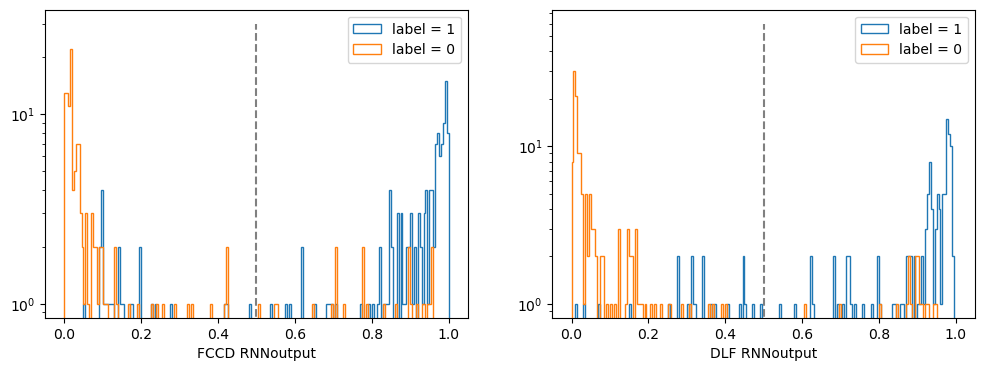

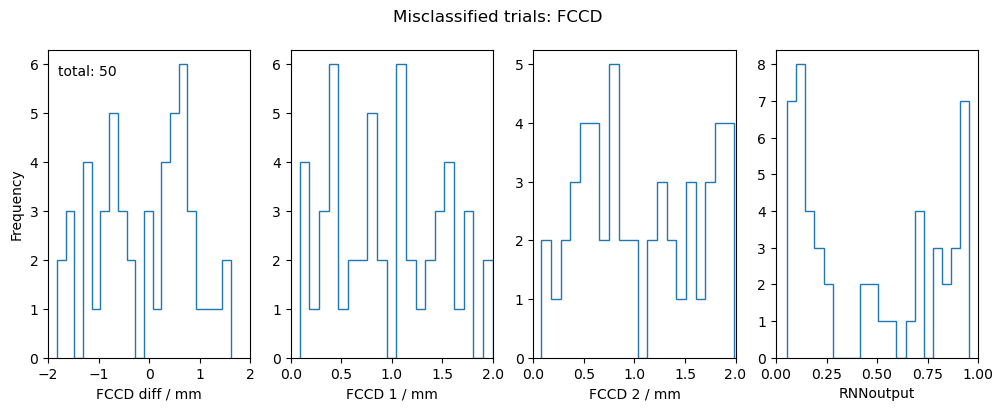

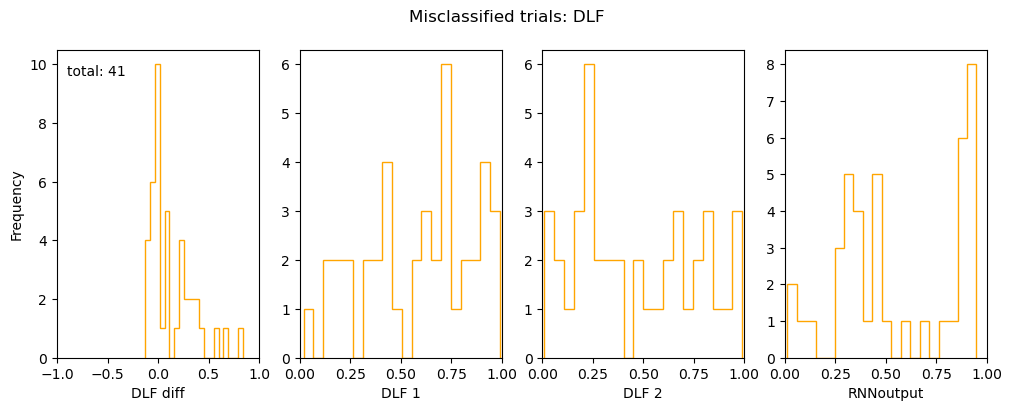

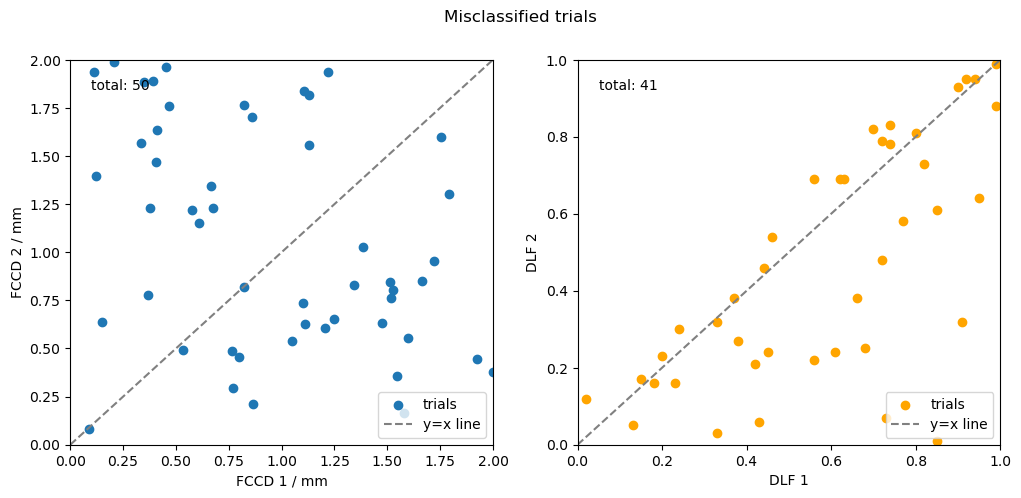

In [33]:
#testing
accuracies_maxFCCDdiff0_25mm = test_RNN(RNNclassifier_maxFCCDdiff0_25mm, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True, train_restricted_test_fulldataset = True)


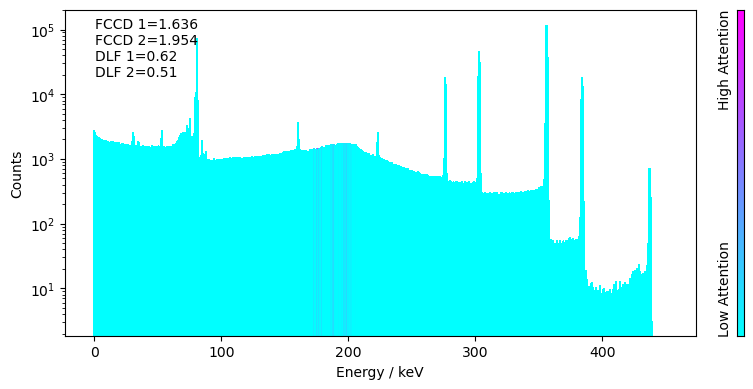

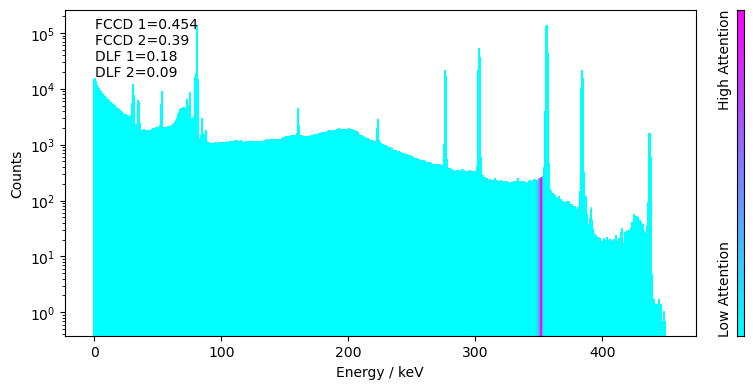

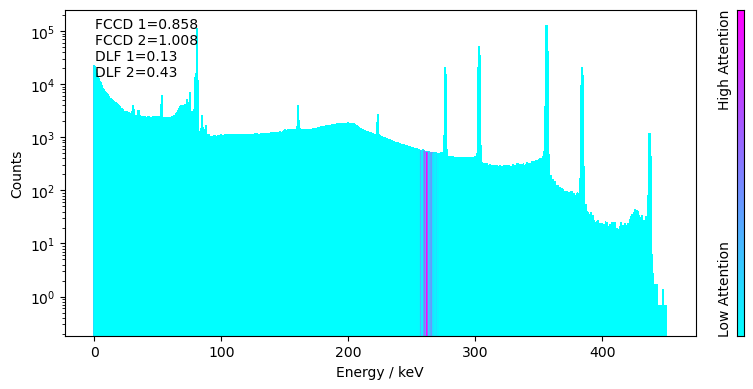

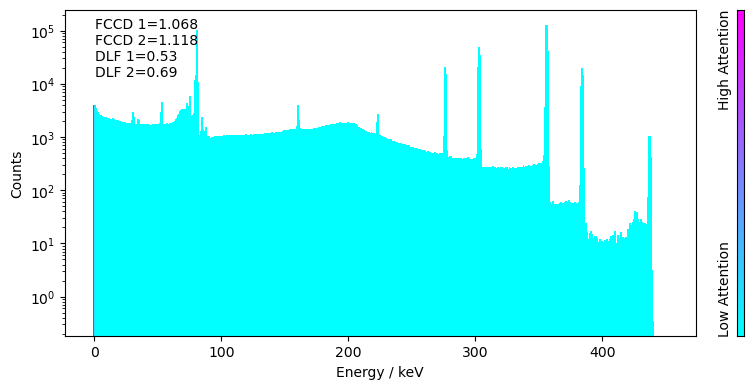

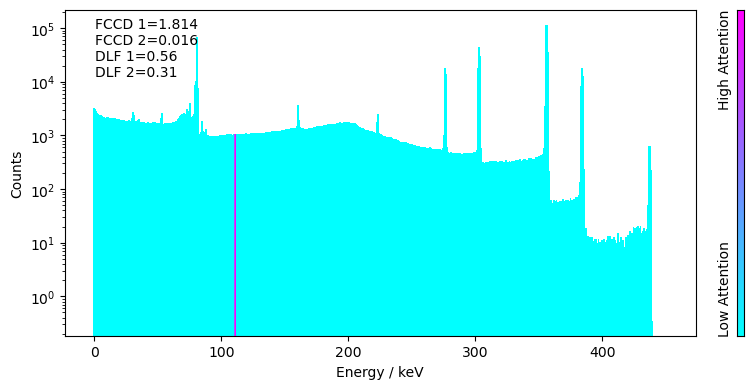

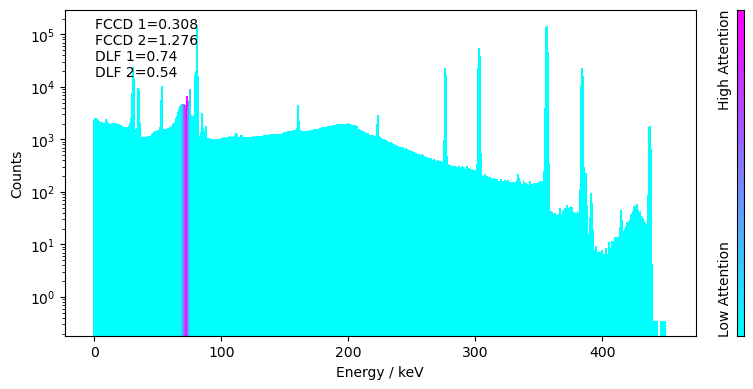

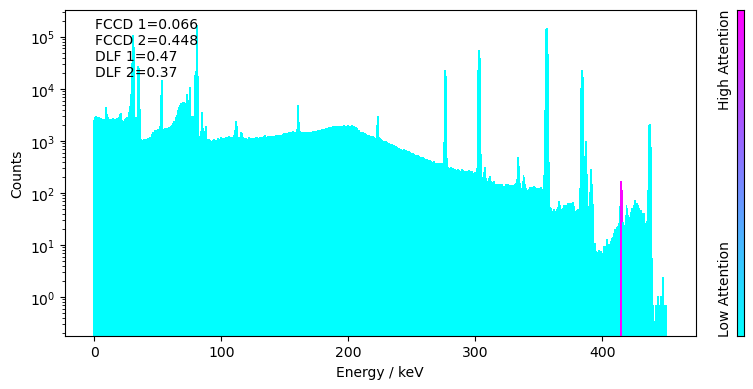

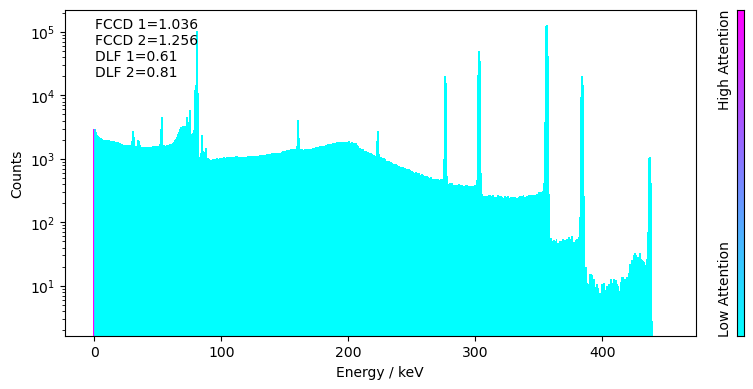

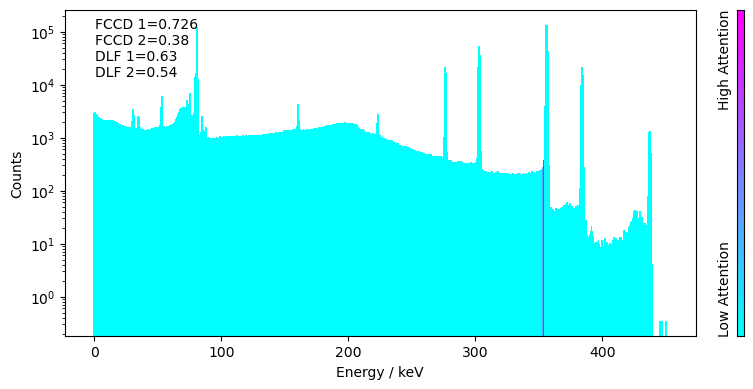

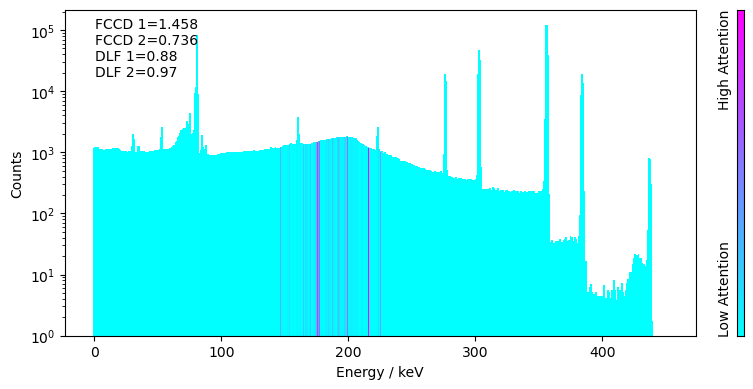

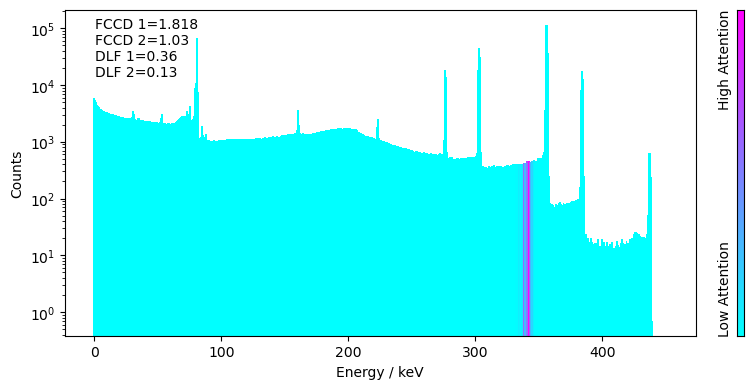

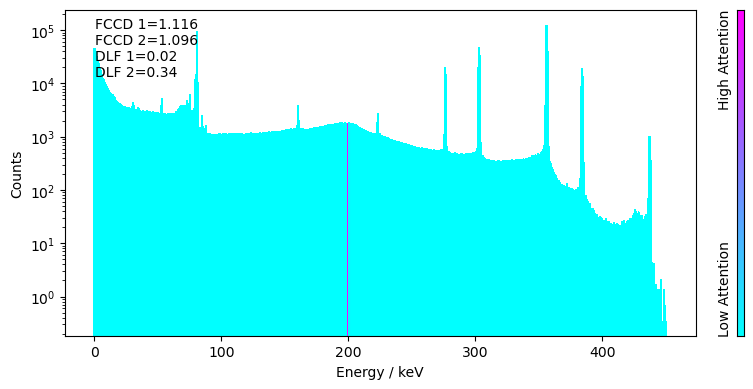

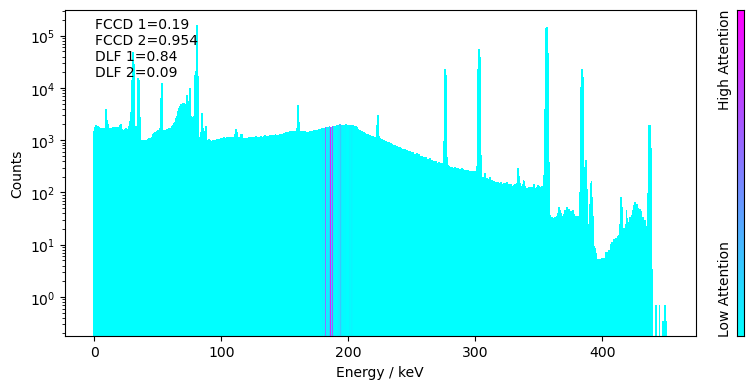

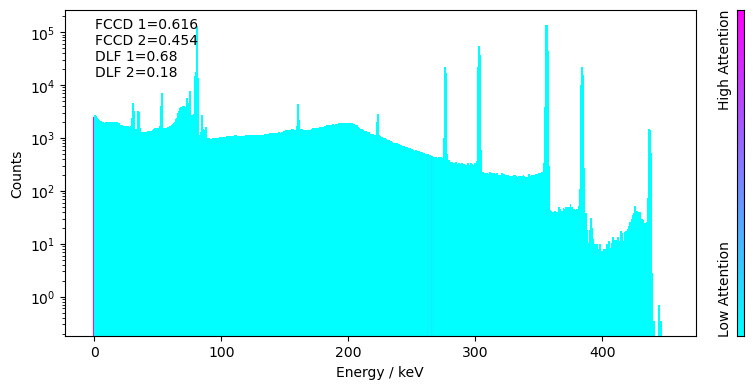

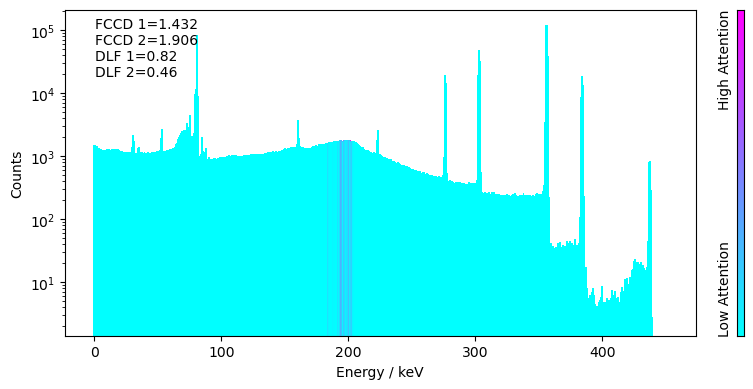

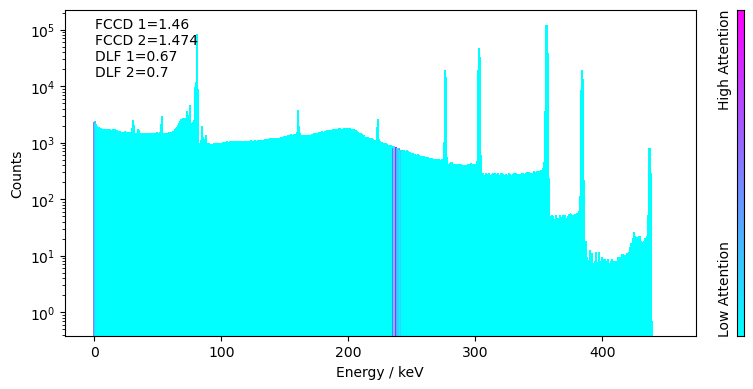

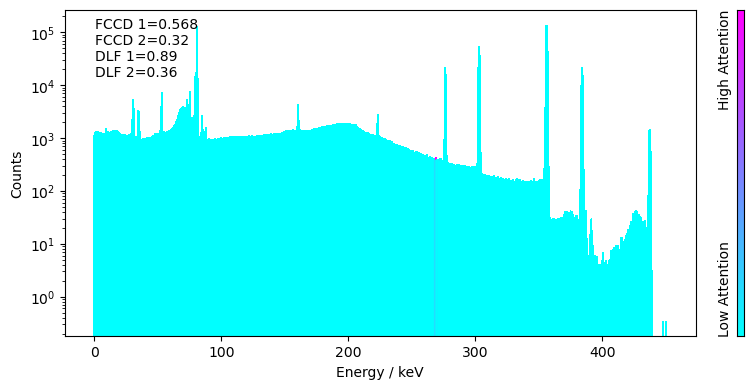

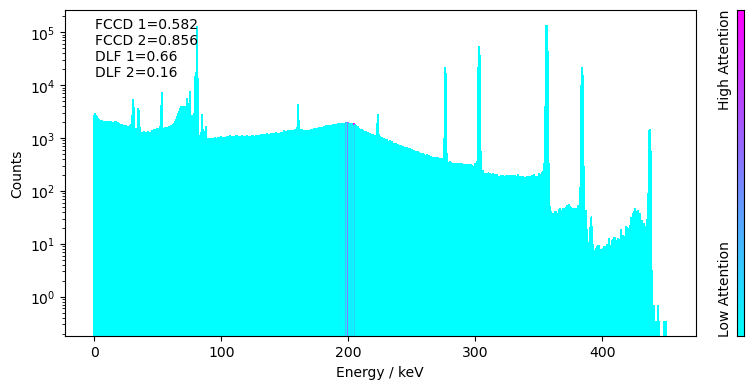

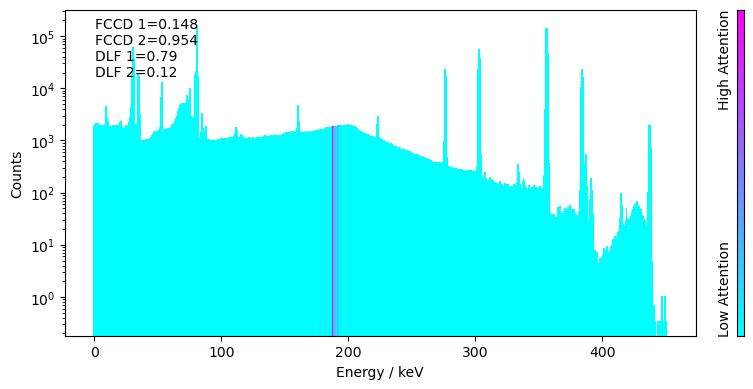

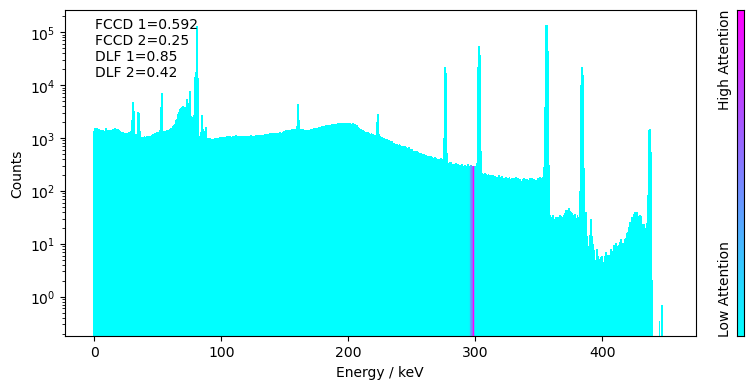

In [34]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention_fulldataset.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# TRAINING 4: restircted dataset - Max FCCD diff = 0.25 mm AND Max DLF diff = 0.25

In [35]:
NUM_EPOCHS = 30 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
maxFCCDdiff = 0.25
maxDLFdiff = 0.25 
RNN_ID = "RNN_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_maxDLFdiff"+str(maxDLFdiff)

#initialise directories to save
if not os.path.exists(CodePath+"/saved_models/"+RNN_ID+"/plots/"):
    os.makedirs(CodePath+"/saved_models/"+RNN_ID+"/plots/")

In [36]:
#load dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.23it/s]

(1000, 900)


## Training - DO NOT RERUN UNLESS NECESARRY

In [ ]:
#Training - do not rerun if not necesarry
# torch.cuda.empty_cache()
FCCD_accuracy_values, DLF_accuracy_values, loss_values = train_RNN(train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, saveRNN=True, plot_training_results = True, RNN_ID = RNN_ID)

In [ ]:
#Training Results
training_results(NUM_EPOCHS, loss_values, FCCD_accuracy_values, DLF_accuracy_values, save_plots = False, RNN_ID = RNN_ID)


## Testing - on maxFCCDdiff=0.25mm and maxDLFdiff=0.25

In [37]:
# Load saved model
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25 = RNN(dataset.get_histlen(),2)
model_path = CodePath+"/saved_models/"+RNN_ID+"/"+RNN_ID+".pkl"
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25.load_state_dict(torch.load(model_path))
RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25.eval()

RNN(
  (RNNLayer): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fcnet): FCNet(
    (fcnet): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (attention_weight): Linear(in_features=512, out_features=512, bias=False)
)

  9%|████████▍                                                                                 | 7/75 [00:00<00:06,  9.92it/s]

DLF and FCCD misclassified for same trial:
j:  4 , i:  3
FCCD1:  0.468 , FCCD2:  0.598 , FCCD_diff:  -0.12999999999999995 , RNNoutput:  0.6831321
DLF1:  0.39 , DLF2:  0.39 , DLF_diff:  0.0 , RNNoutput:  0.038233772


100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.04it/s]


FCCD accuracies: 
total:  300
TP:  140
FP:  13
TN:  135
FN:  12
accuracy:  0.9166666666666666
precision:  0.9150326797385621
recall:  0.9210526315789473

DLF accuracies: 
total:  300
TP:  146
FP:  10
TN:  129
FN:  15
accuracy:  0.9166666666666666
precision:  0.9358974358974359
recall:  0.906832298136646
Total # misclassified trials FCCD:  25  / 300
Total # misclassified trials DLF:  25  / 300


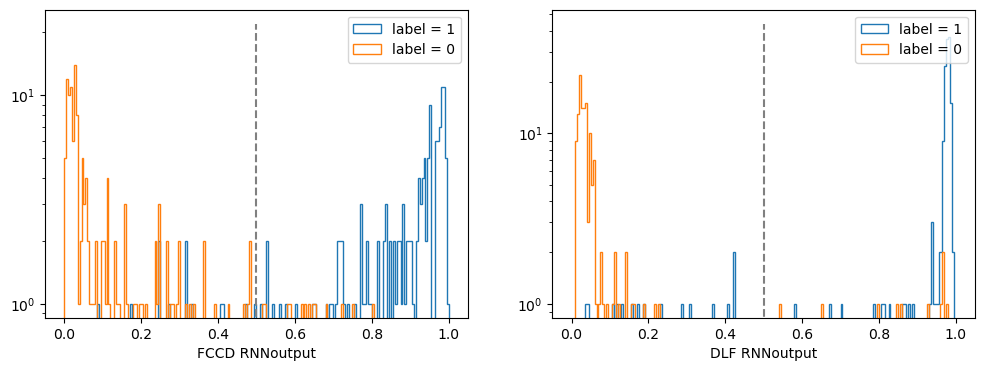

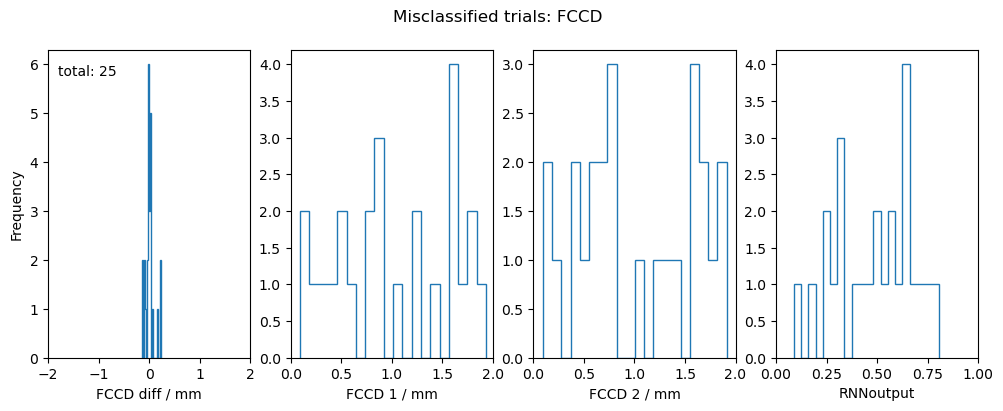

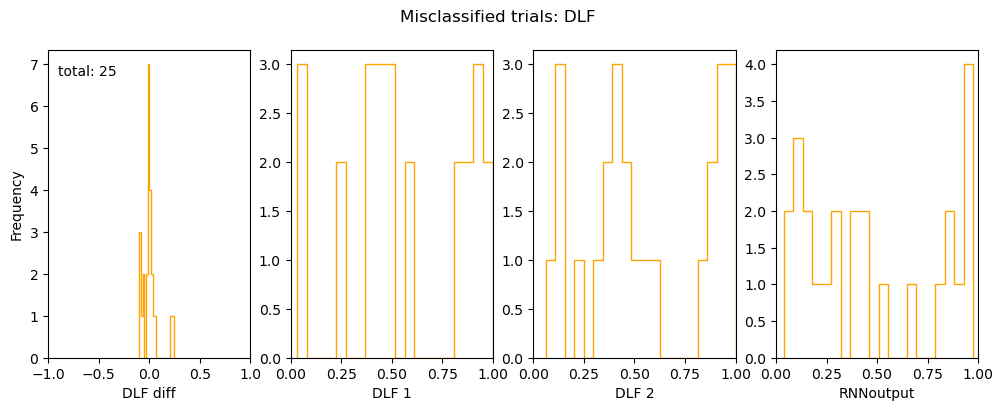

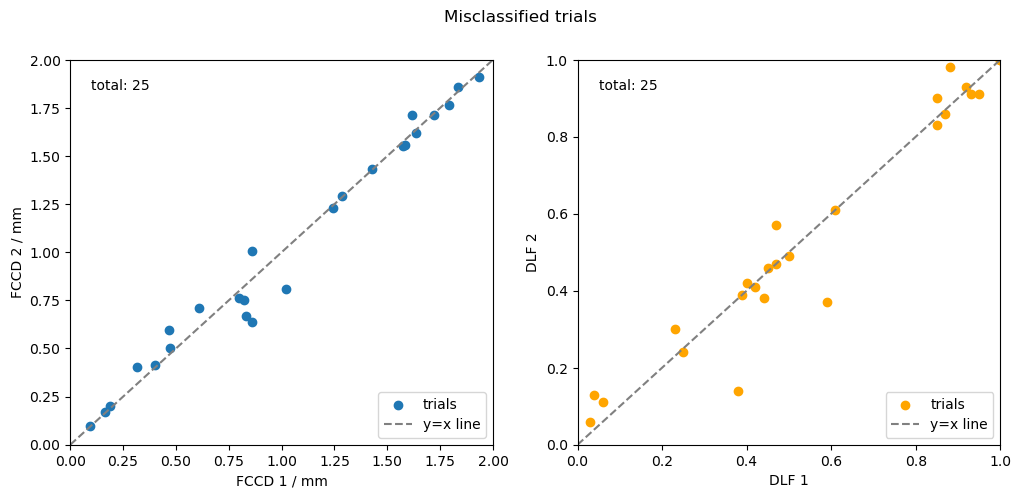

In [38]:
#testing
accuracies_maxFCCDdiff0_25mm_maxDLFdiff0_25 = test_RNN(RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True)


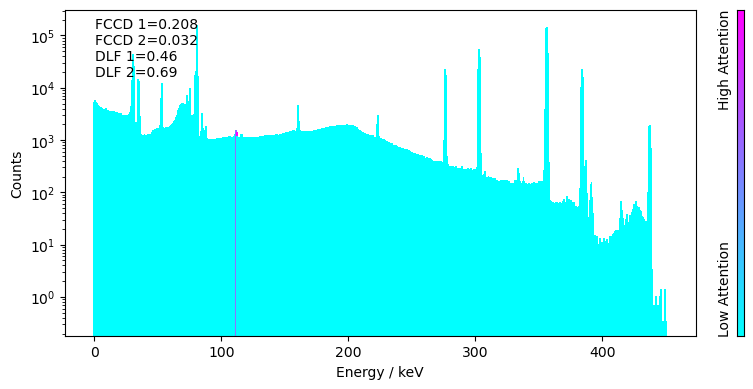

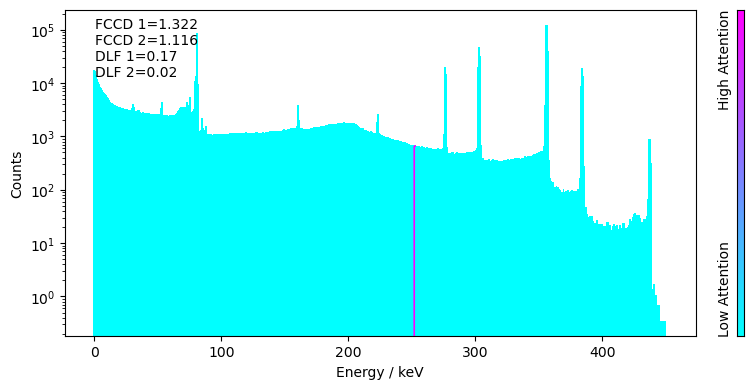

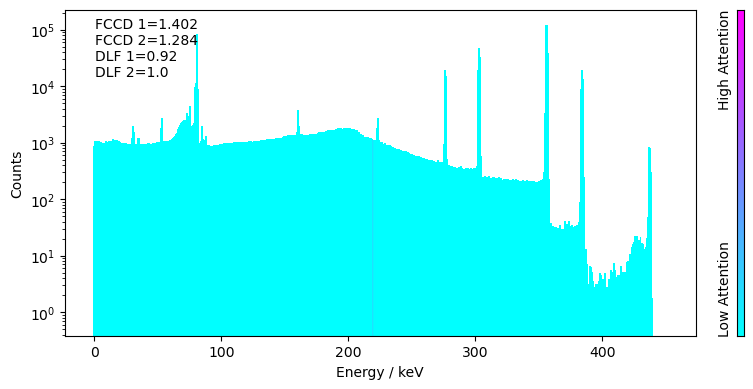

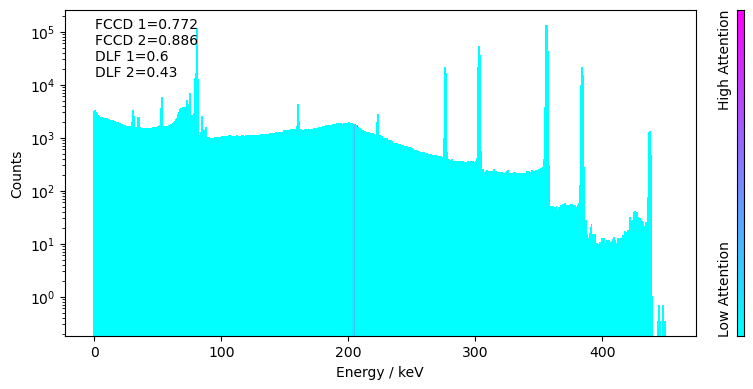

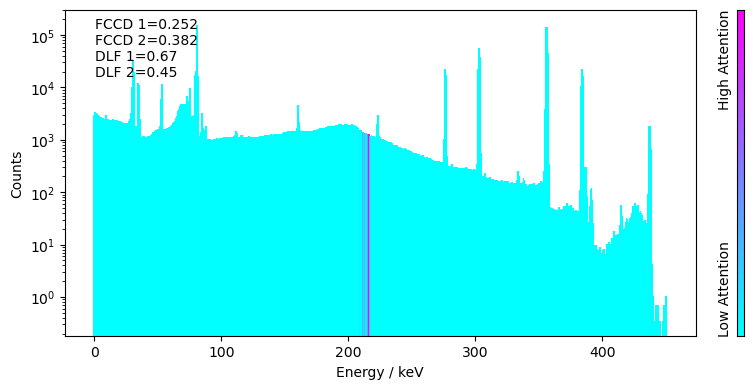

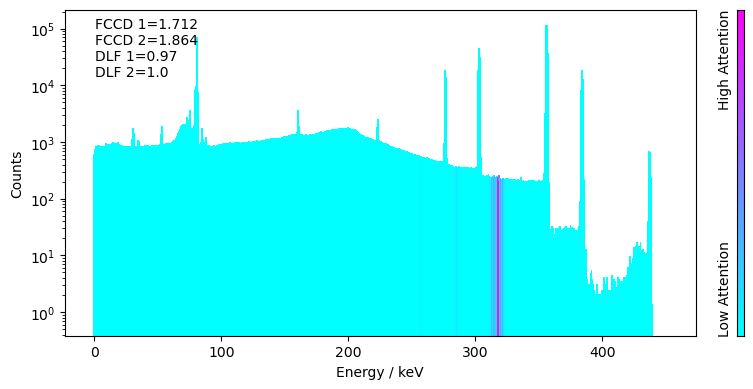

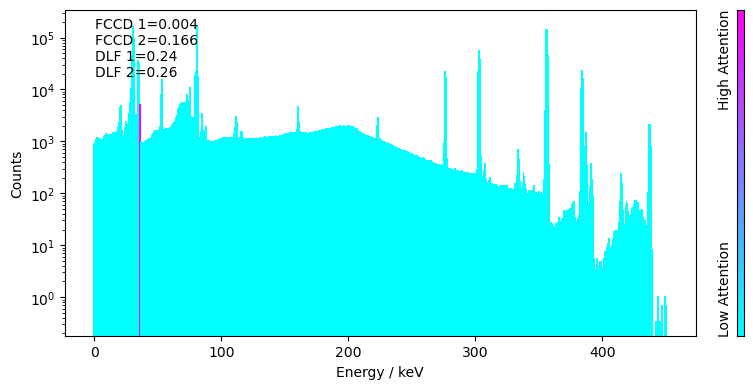

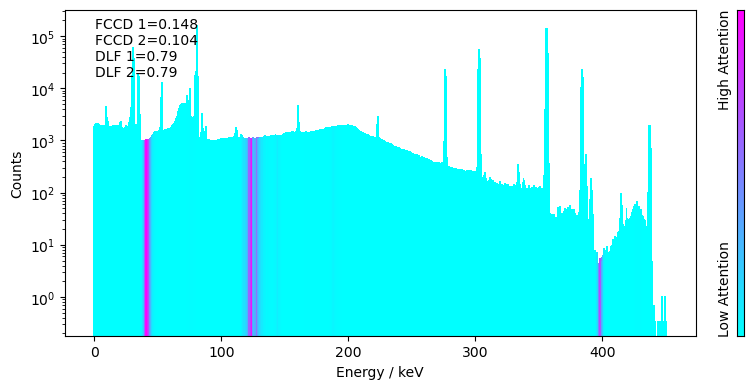

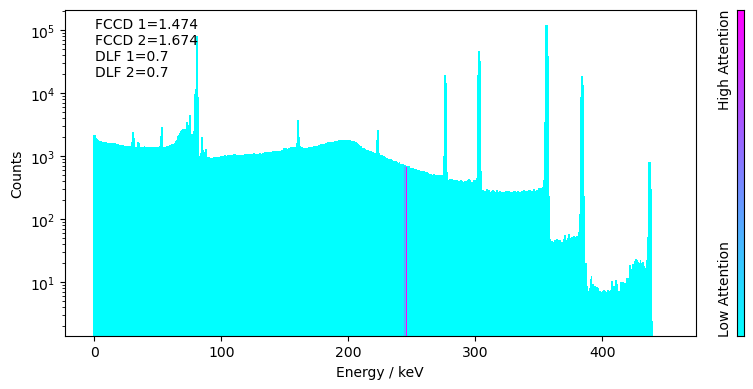

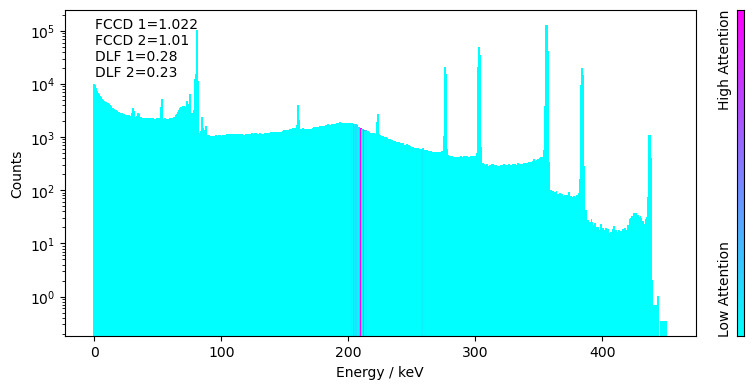

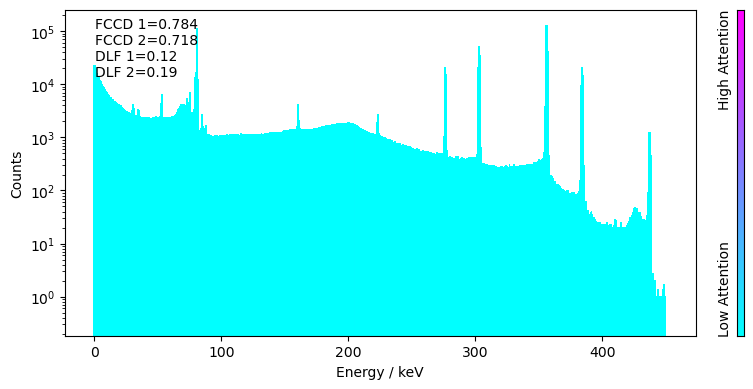

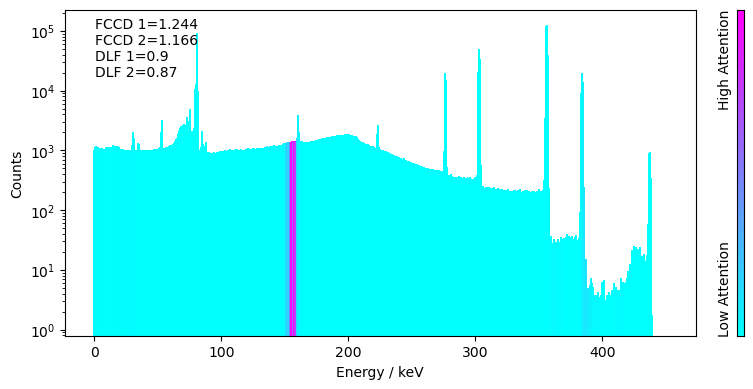

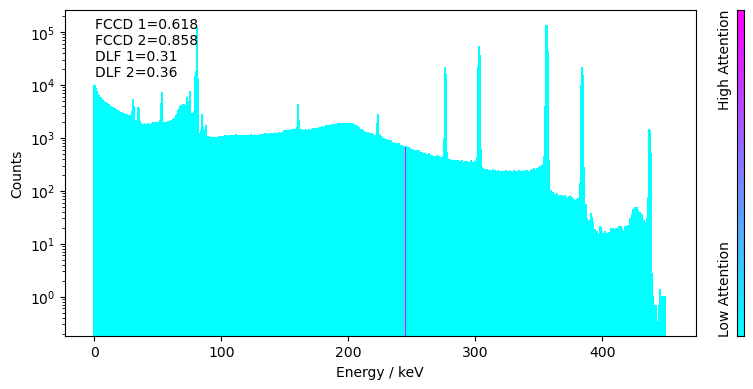

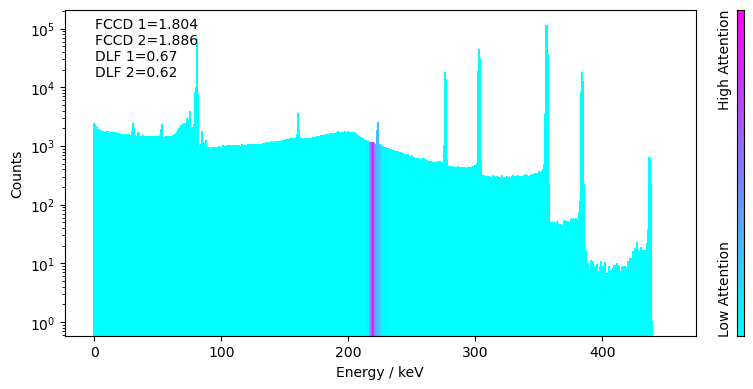

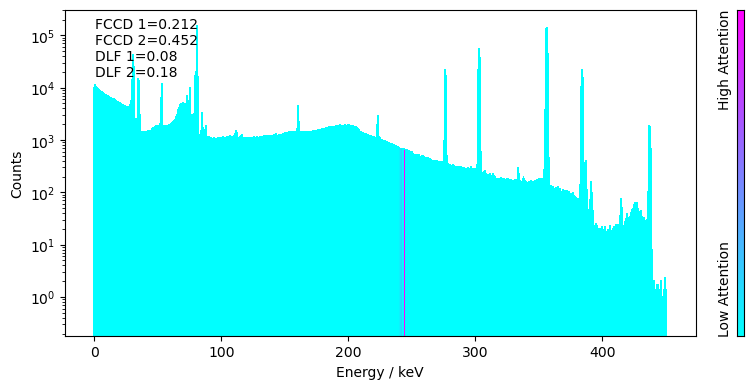

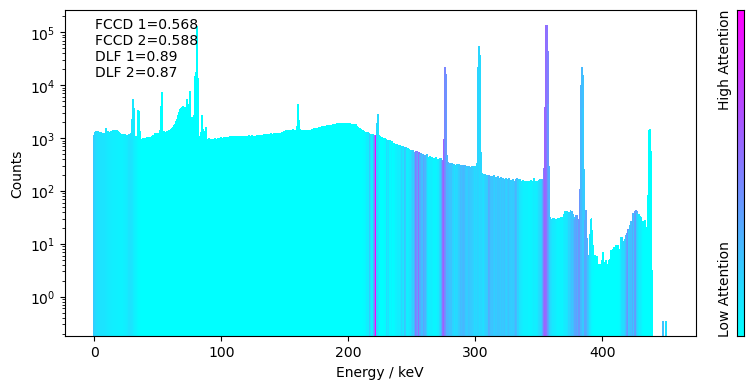

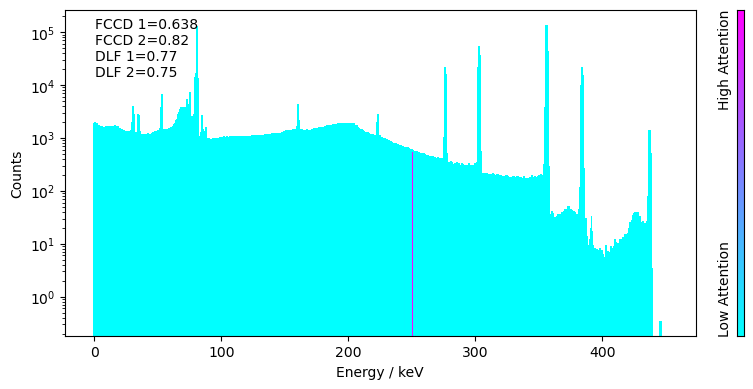

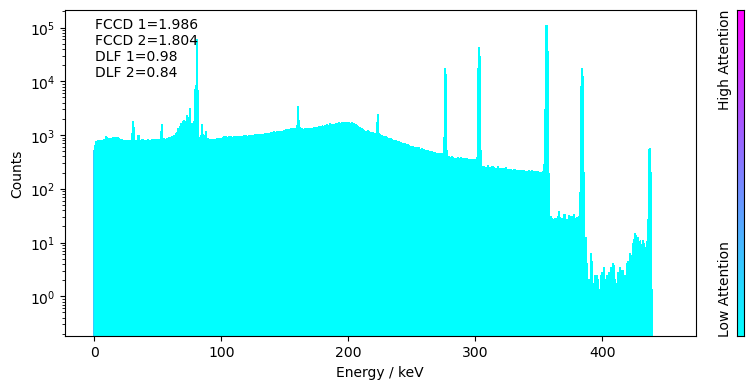

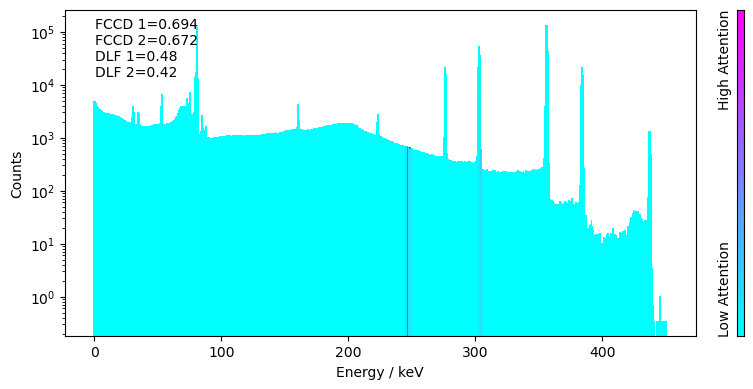

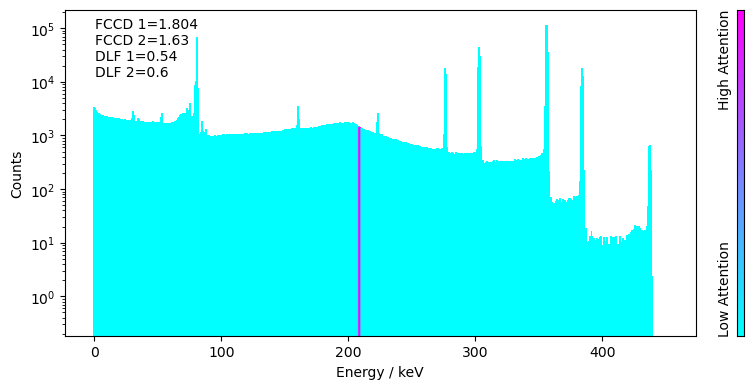

In [39]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

## Testing - on full dataset

In [40]:
train_loader, test_loader, dataset = load_data(BATCH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.27it/s]

(1000, 900)


  8%|███████▏                                                                                  | 6/75 [00:00<00:06, 10.66it/s]

DLF and FCCD misclassified for same trial:
j:  4 , i:  3
FCCD1:  1.556 , FCCD2:  0.438 , FCCD_diff:  1.118 , RNNoutput:  0.35529226
DLF1:  0.39 , DLF2:  0.41 , DLF_diff:  -0.019999999999999962 , RNNoutput:  0.78853446


 29%|██████████████████████████                                                               | 22/75 [00:02<00:04, 10.98it/s]

DLF and FCCD misclassified for same trial:
j:  19 , i:  1
FCCD1:  1.494 , FCCD2:  0.156 , FCCD_diff:  1.338 , RNNoutput:  0.4678221
DLF1:  0.41 , DLF2:  0.54 , DLF_diff:  -0.13000000000000006 , RNNoutput:  0.8301491


100%|█████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 10.99it/s]


FCCD accuracies: 
total:  300
TP:  113
FP:  8
TN:  146
FN:  33
accuracy:  0.8633333333333333
precision:  0.9338842975206612
recall:  0.773972602739726

DLF accuracies: 
total:  300
TP:  135
FP:  13
TN:  145
FN:  7
accuracy:  0.9333333333333333
precision:  0.9121621621621622
recall:  0.9507042253521126
Total # misclassified trials FCCD:  41  / 300
Total # misclassified trials DLF:  20  / 300


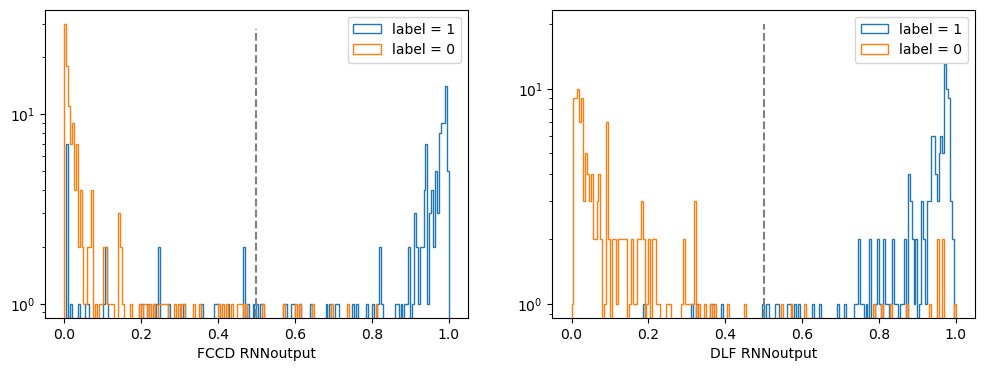

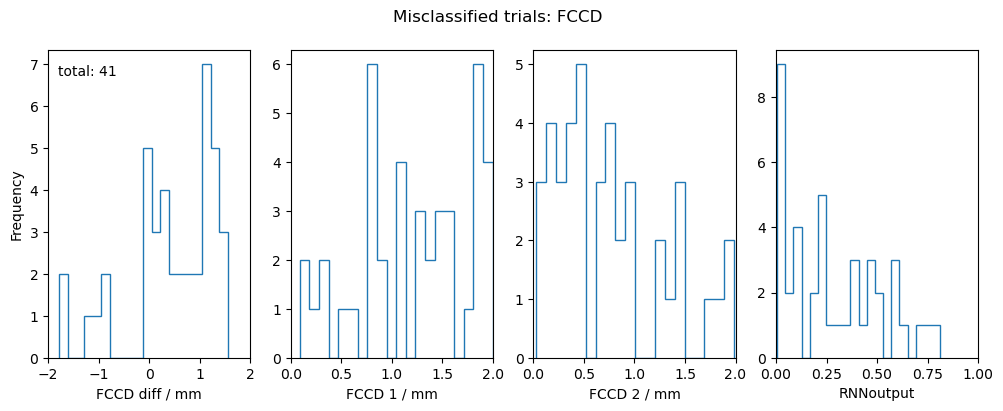

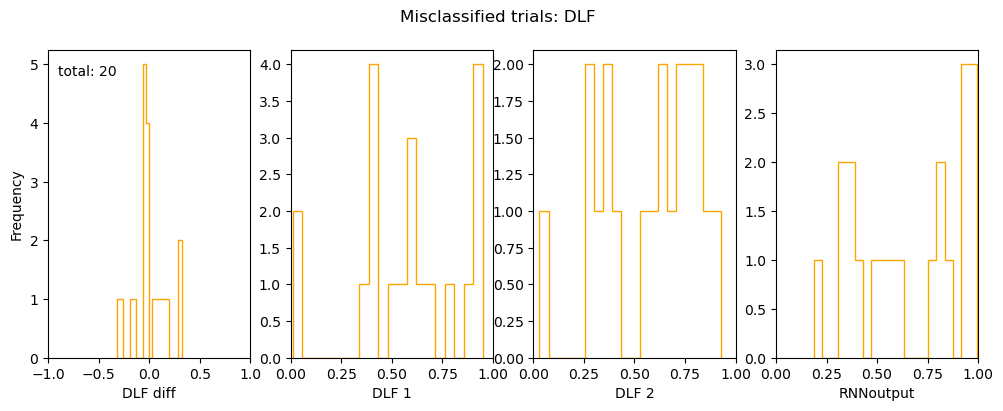

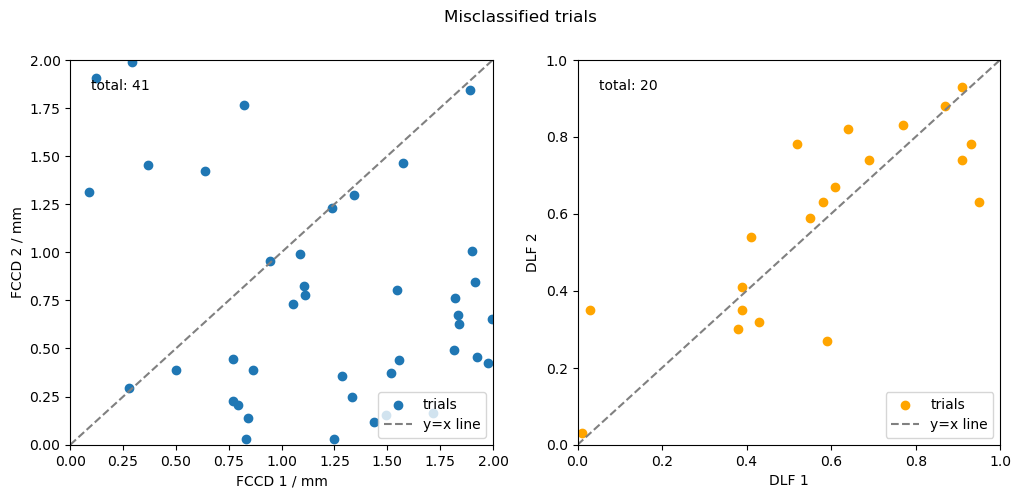

In [41]:
#testing
accuracies_maxFCCDdiff0_25mm_maxDLFdiff0_25 = test_RNN(RNNclassifier_maxFCCDdiff0_25mm_maxDLFdiff0_25, test_loader, RNN_ID=RNN_ID, performance_plots = True, misclassified_trials_plots = True, save_results = True, train_restricted_test_fulldataset = True)


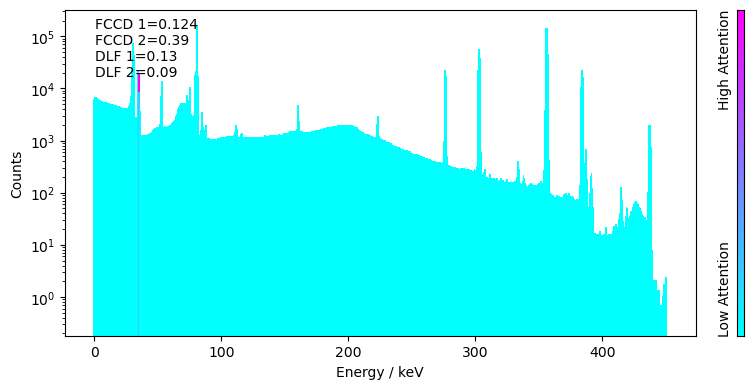

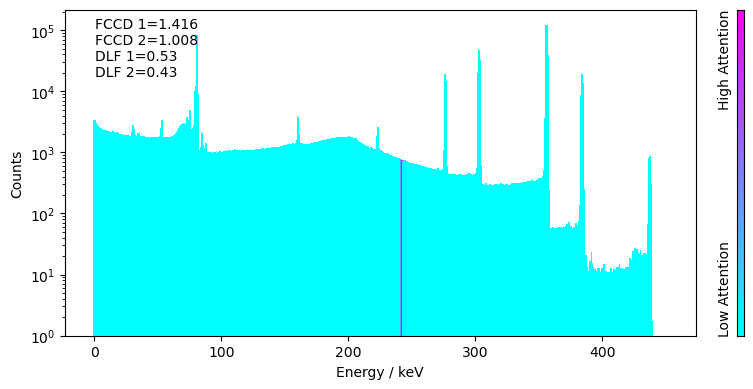

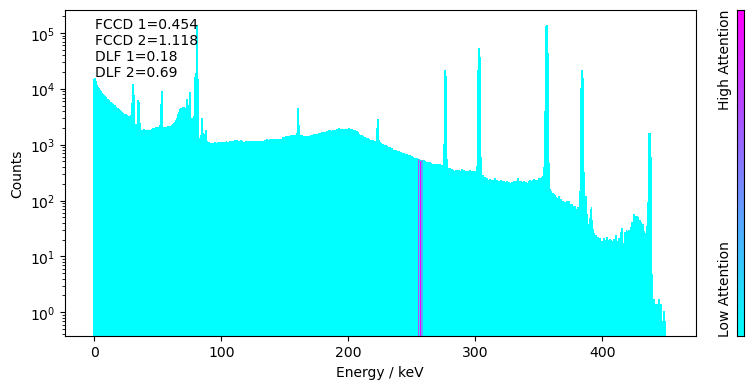

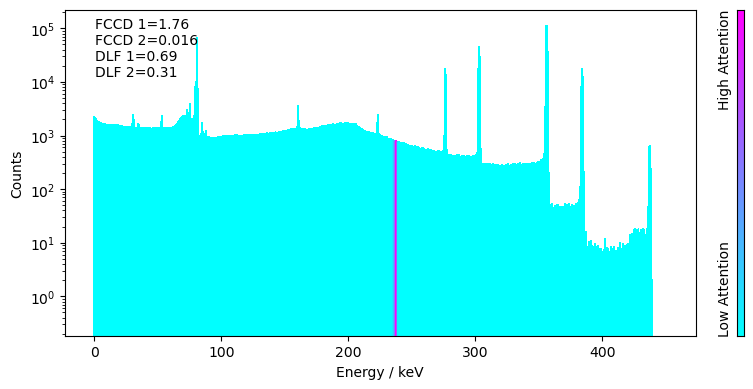

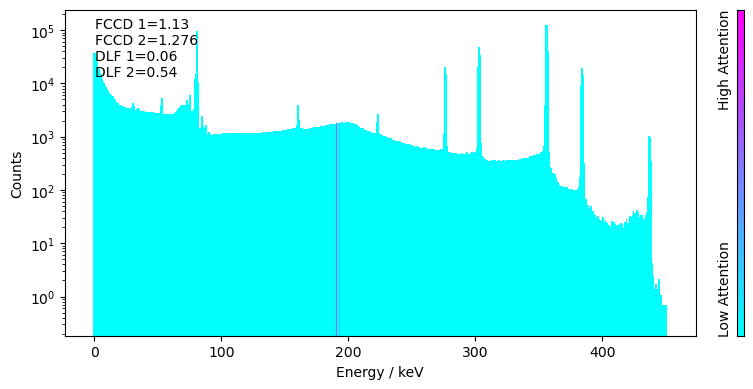

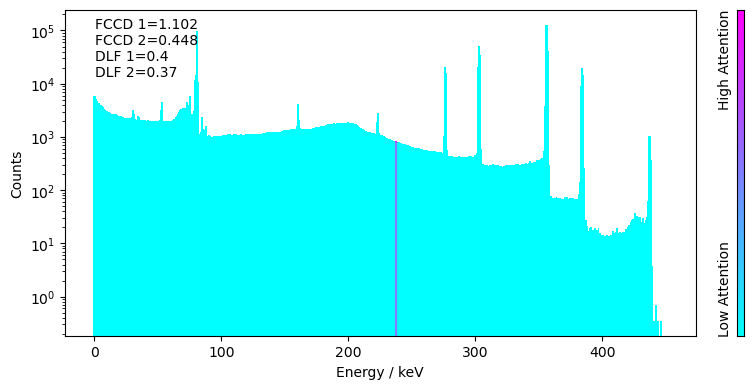

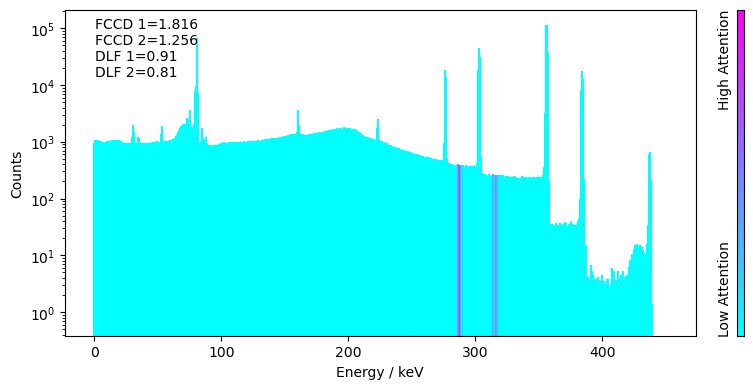

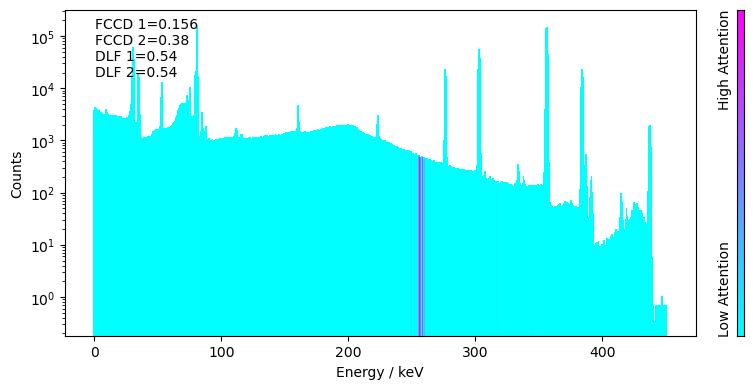

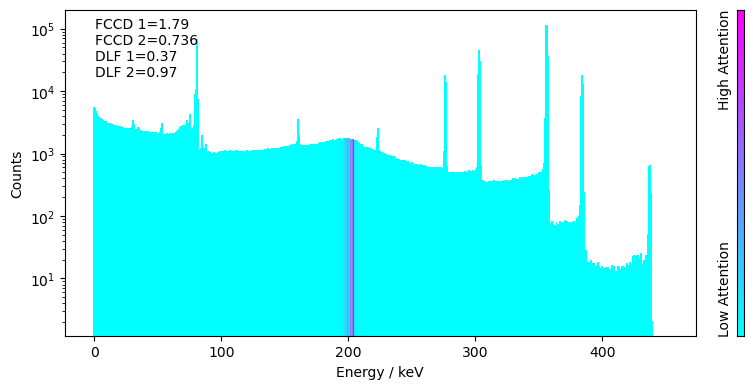

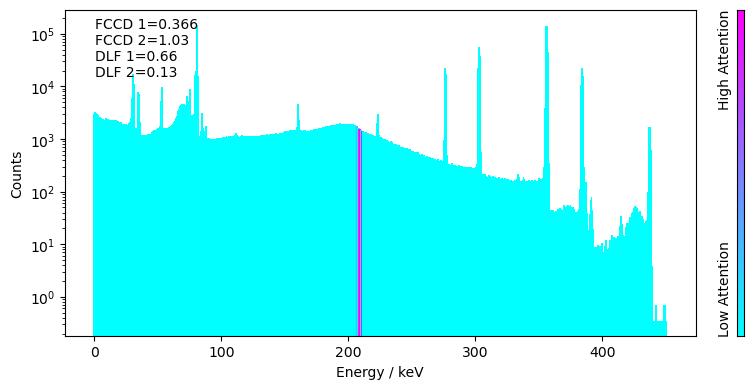

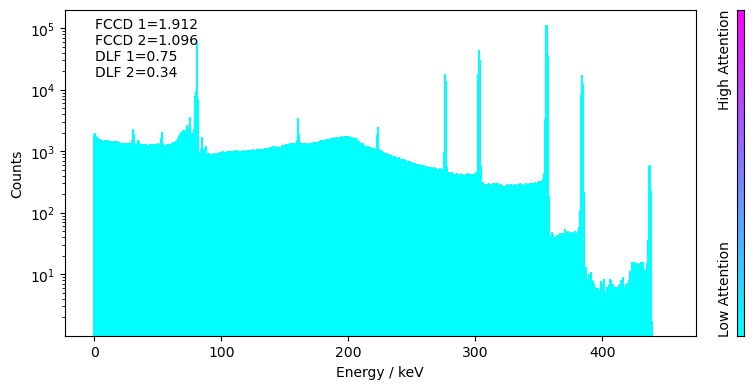

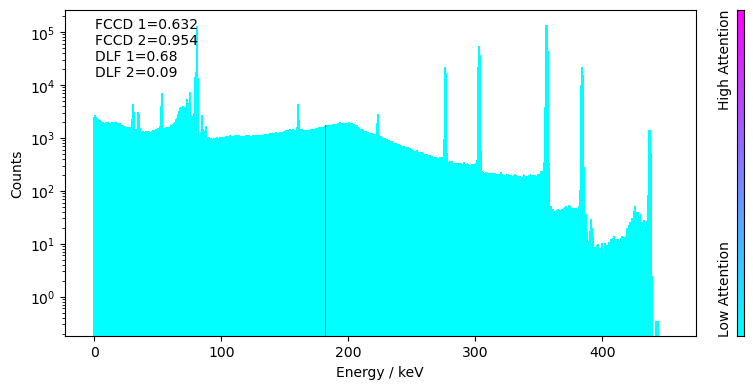

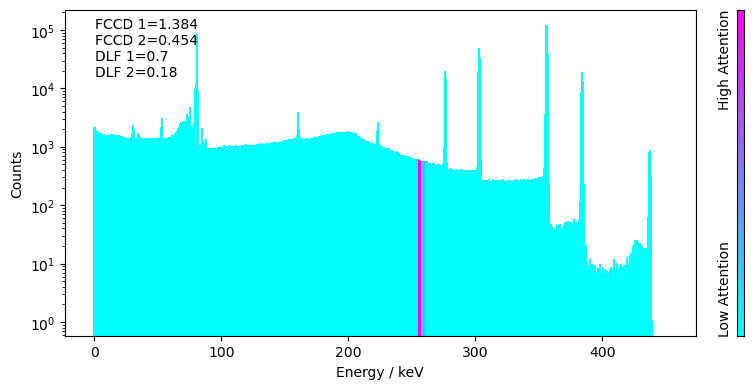

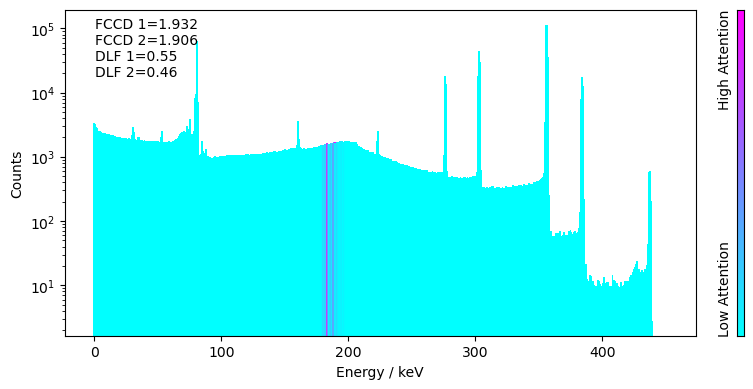

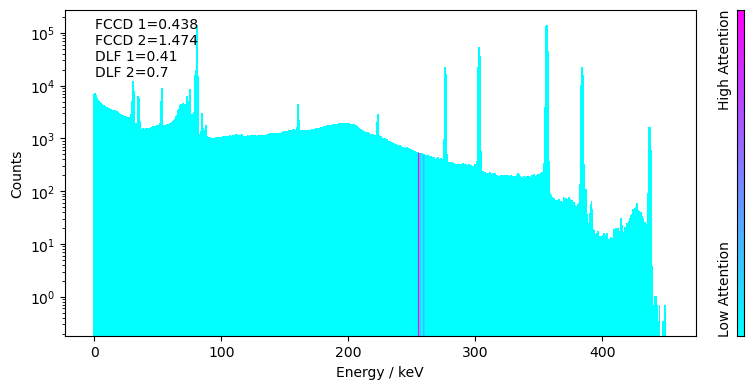

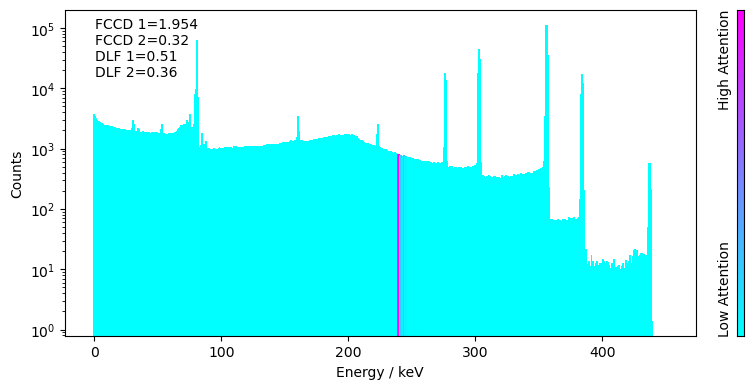

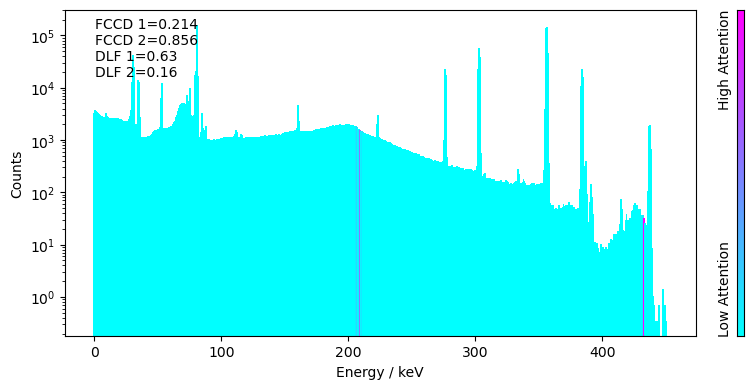

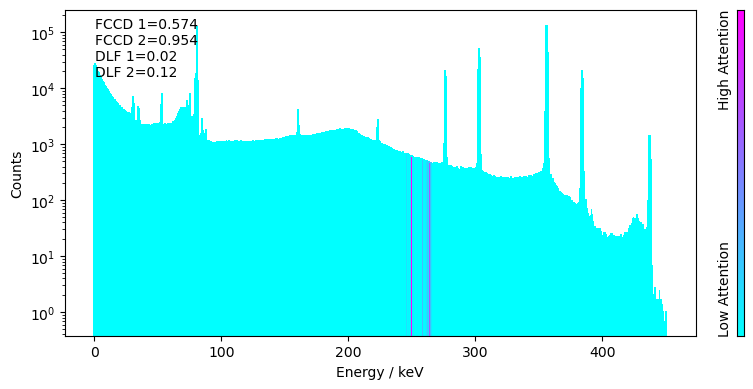

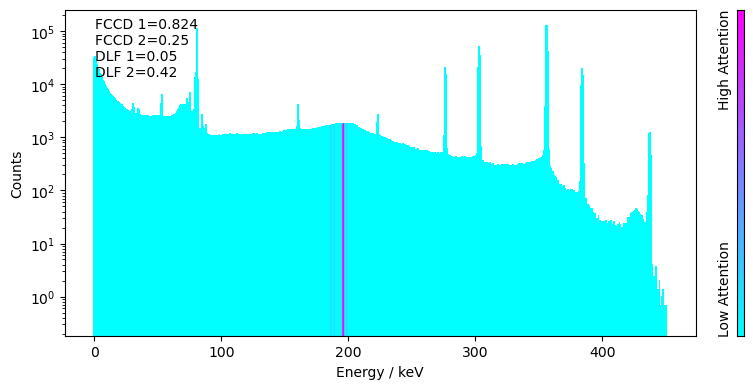

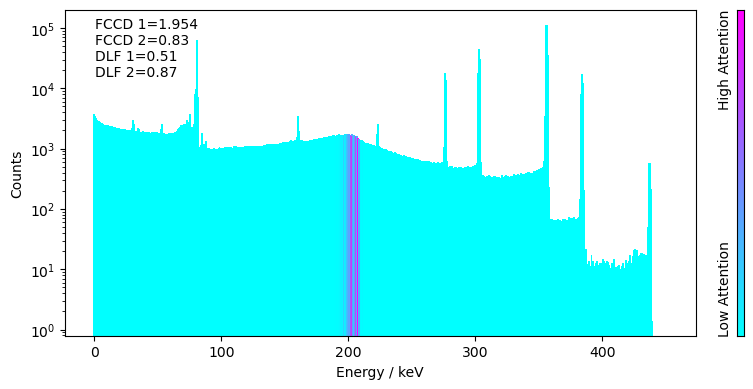

In [42]:
#Investigate Attention

#Make RNNinterpretor object and set get_attention to true
RNNinterpretor = RNN(dataset.get_histlen(),2)
RNNinterpretor.get_attention = True

#Load trained RNN dict to this
RNNinterpretor.load_state_dict(torch.load(model_path))
RNNinterpretor.eval()
RNNinterpretor.to(DEVICE)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(CodePath+"/saved_models/"+RNN_ID+"/plots/test_attention_fulldataset.pdf")
   
for a in range (5):
    #Load a test events through interpretor
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum_diff = test_spectrum_diff.to(DEVICE).float()

    attention_score = RNNinterpretor(test_spectrum_diff)

    for i in range(BATCH_SIZE):
        attention = attention_score[i].cpu().detach().numpy()
        labels = {"FCCD1": test_extras["FCCD1"][i].item(), "FCCD2": test_extras["FCCD2"][i].item(), "DLF1": test_extras["DLF1"][i].item(), "DLF2": test_extras["DLF2"][i].item()}

        #plot attention score on spectrum
        fig = plot_attention(test_spectrum[i], attention, labels)
        pdf.savefig(fig)

pdf.close()

# ------------------------------------------
# Comparing RNNs
# ------------------------------------------

### -----------------------------------------------------------
# Questions to ask:

- **Why warm up attention mechanism?:**

*Answer: This is a special treatment for attention mechanism. The idea of warmup is to use very low learning rate at the beginning and then gradually increase the learning rate to nominal value. If we do this, the attention mechanism will be able to get a first sense of how the data looks like with those very low learning rate epochs. There are some papers you can read, but I think they are too technical and I don’t want you to get too deep into those technical details.*


- **Why does binary cross entropy loss value oscillate between epochs?**

*Answer: the main reason of oscillation is because of the stochastic training behavior. Stochastic Gradient Descent (SGD) is the base template of all ML optimizers. The idea of SGD is to randomly draw mini-batches from the entire dataset and train. Since the drawing is random, everytime it will introduce some stochasticity into the training, that’s the main reason your loss is oscillating. To me it looks very normal.*



- **Saving trained model -> how do you also save the train/test split/seed so that we dont test on data that was used for training?**

*Answer: I think for your case you don’t quite need to worry about overlapping between training/testing dataset just yet, because each of your data is a residual of subtraction of two spectrums. The probability that you have subtracted exactly two identical spectrums is low.*


- **Should there be an attention score for DLF and FCCD?**

*Answer: There is only one set of attention score, because the RNN is making a joint decisions to determine DLF and FCCD simultaneously. So ideally the attention score would show the part that both indicates FCCD and DLF differences.*


- **Attention plots: should I plot spectrum 1 and 2 for each sample? Should I average over multiple spectra so we can observe the overall trends?**



- **Restricted training: on both FCCD and DLF? Take in turns?**



- **After training on restricted dataset (e.g. maxFCCDdiff=0.5mm), should the testing/accuracy evaluation be performed on the test_loader of this restricted dataset, or the test_loader of the full dataset? Note that the performance on the whole dataset when trained on a restircted dataset is generally worse**


- **Restricted training: When maxFCCDdiff is restricted to 0.25mm, the RNN performs worse. Should I edit training parameters (i.e. increase no epochs, LR, etc) in order to try to improve the performance?**



Notes:
- make 2 attention plots, 1 like the one i already have, and one power spectrum/stacked histogram of all the attention scores in one -> just plot multiple attention on same graph
- just restrict FCCD (not DLF) and make as small as possible - i.e. to the resolution of traditional method
- to increase statistics, repetitively call testloader
- try training with 10,000 events instead
- try other attention mechanisam - compare graphs and see which makes more physical sense




In [ ]:

#     binwidth = 0.5 #keV
#     bins = np.arange(0,450+binwidth,binwidth)
#     bins_centres = np.delete(bins+binwidth/2,-1)


#     # data values
#     data_spectrum = torch.tensor(dataset.get_data()).to(DEVICE).float()
#     data_outputs = RNNclassifier(data_spectrum)
#     data_outputs = data_outputs.cpu().data.numpy()#.flatten()
#     data_out_index = np.argmax(data_outputs)